In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [3]:
import display
import dataloader
from dataloader import ThermalData
import clustering
import anomaly_detection

In [4]:
import module_extraction
from module_extraction import Filters, Modules

In [5]:
thermal_npdat_path = "../ModuleExtraction/hokuto/thermal"
input_img_path = '../ModuleExtraction/hokuto/thermal/DJI_0123_R.JPG'

画像データの取得

In [6]:
thermal_img_files = dataloader.get_img_files(dir_path="./images_hokuto/modules",gray=False)
thermal_img_files_gray = dataloader.get_img_files(dir_path="./images_hokuto/modules",gray=True)

In [7]:
type(thermal_img_files), len(thermal_img_files)

(dict, 158)

各モジュールの位置情報を取得

In [8]:
filters = Filters(thermal_npdat_path)
img_org = cv2.imread(input_img_path, 0)
img_filtered = filters.apply_all_filters(img_org)

In [9]:
modules = Modules(img_filtered)
img_con = modules.get_img_contours(img_org, index=True)

/Users/tnozawa/afterFIT/work/rule_based_anomaly_detection/module_extraction.py:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


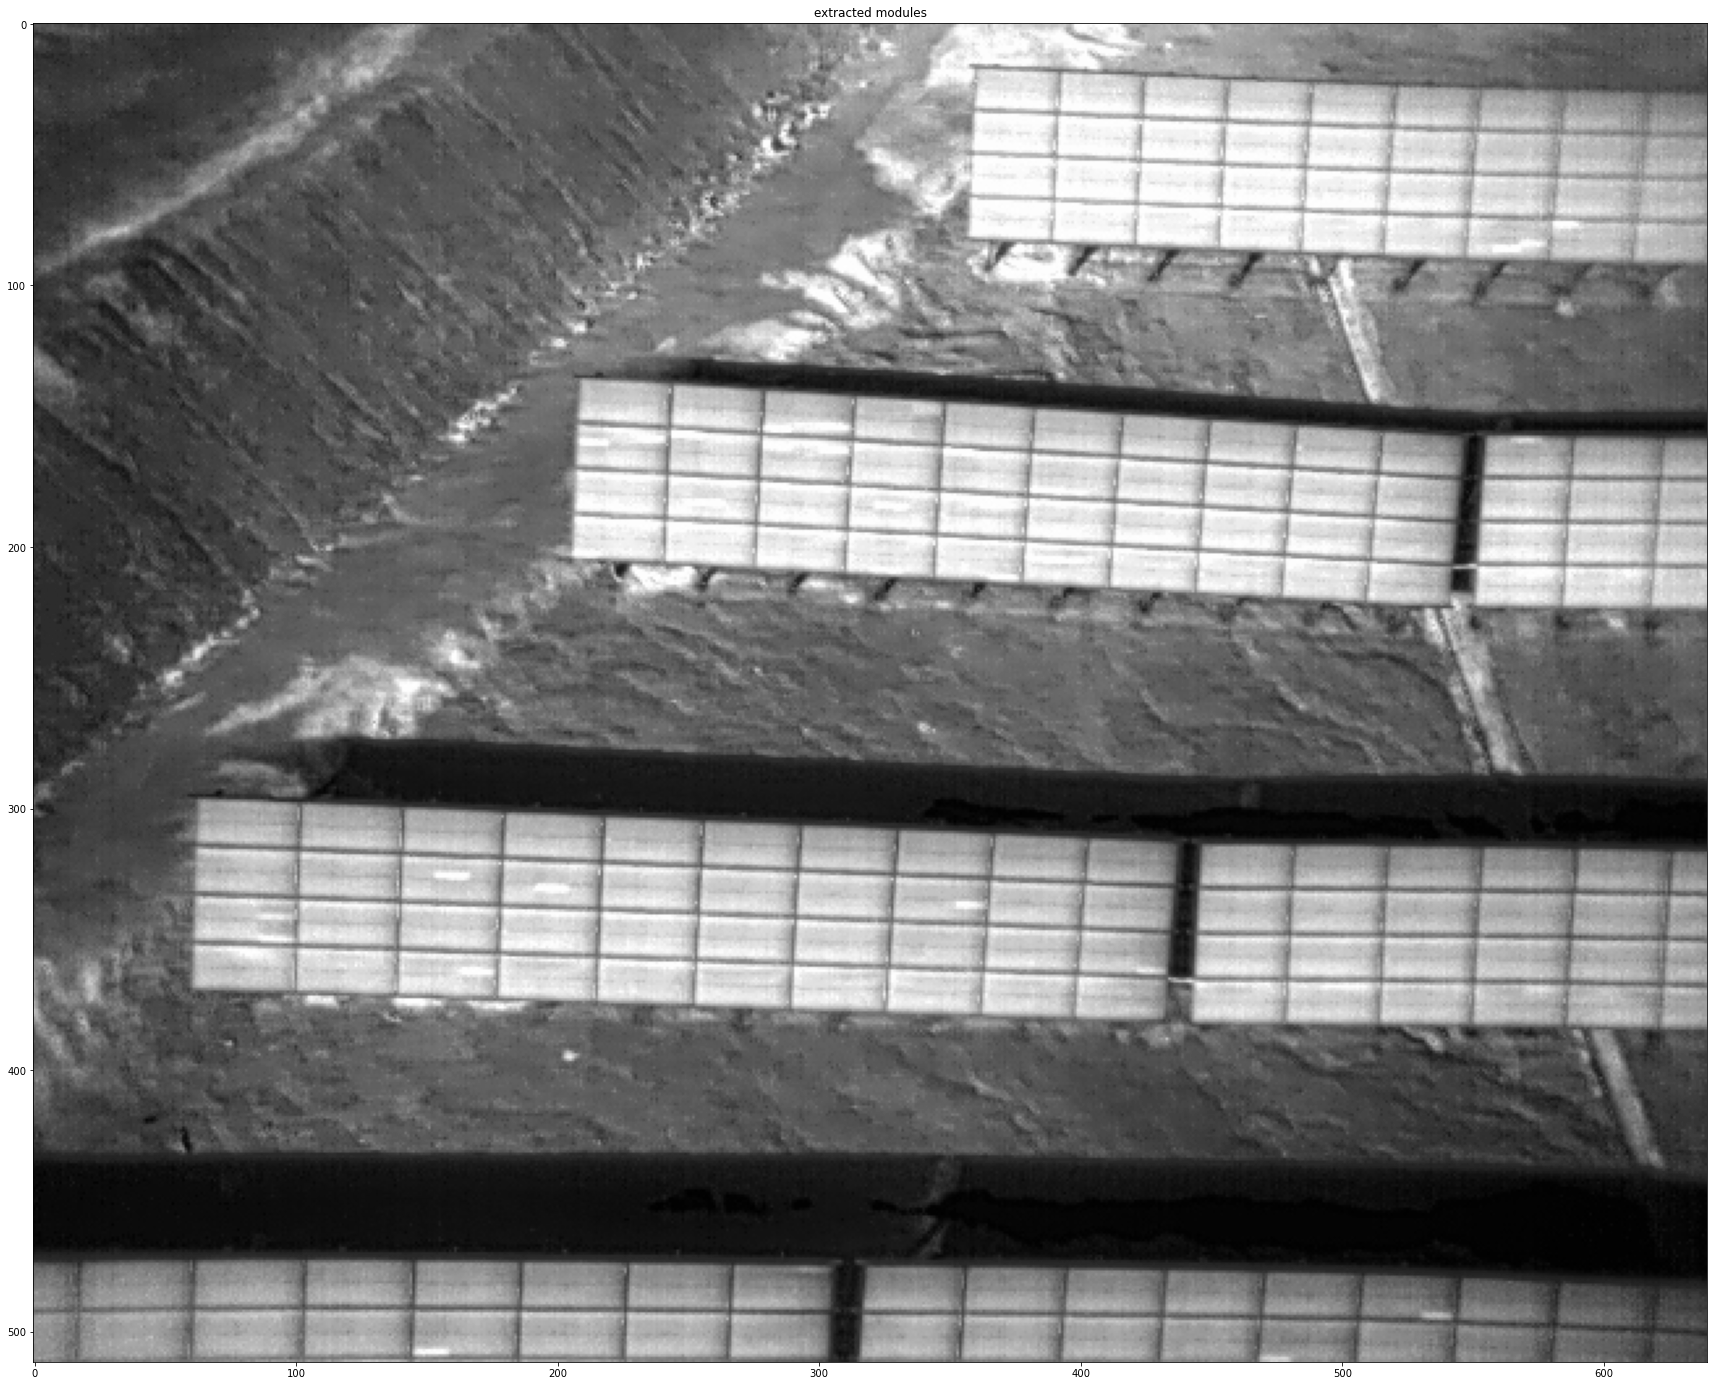

In [10]:
module_extraction.show_img({"extracted modules":img_org},cmap="gray",figsize=(30,30))

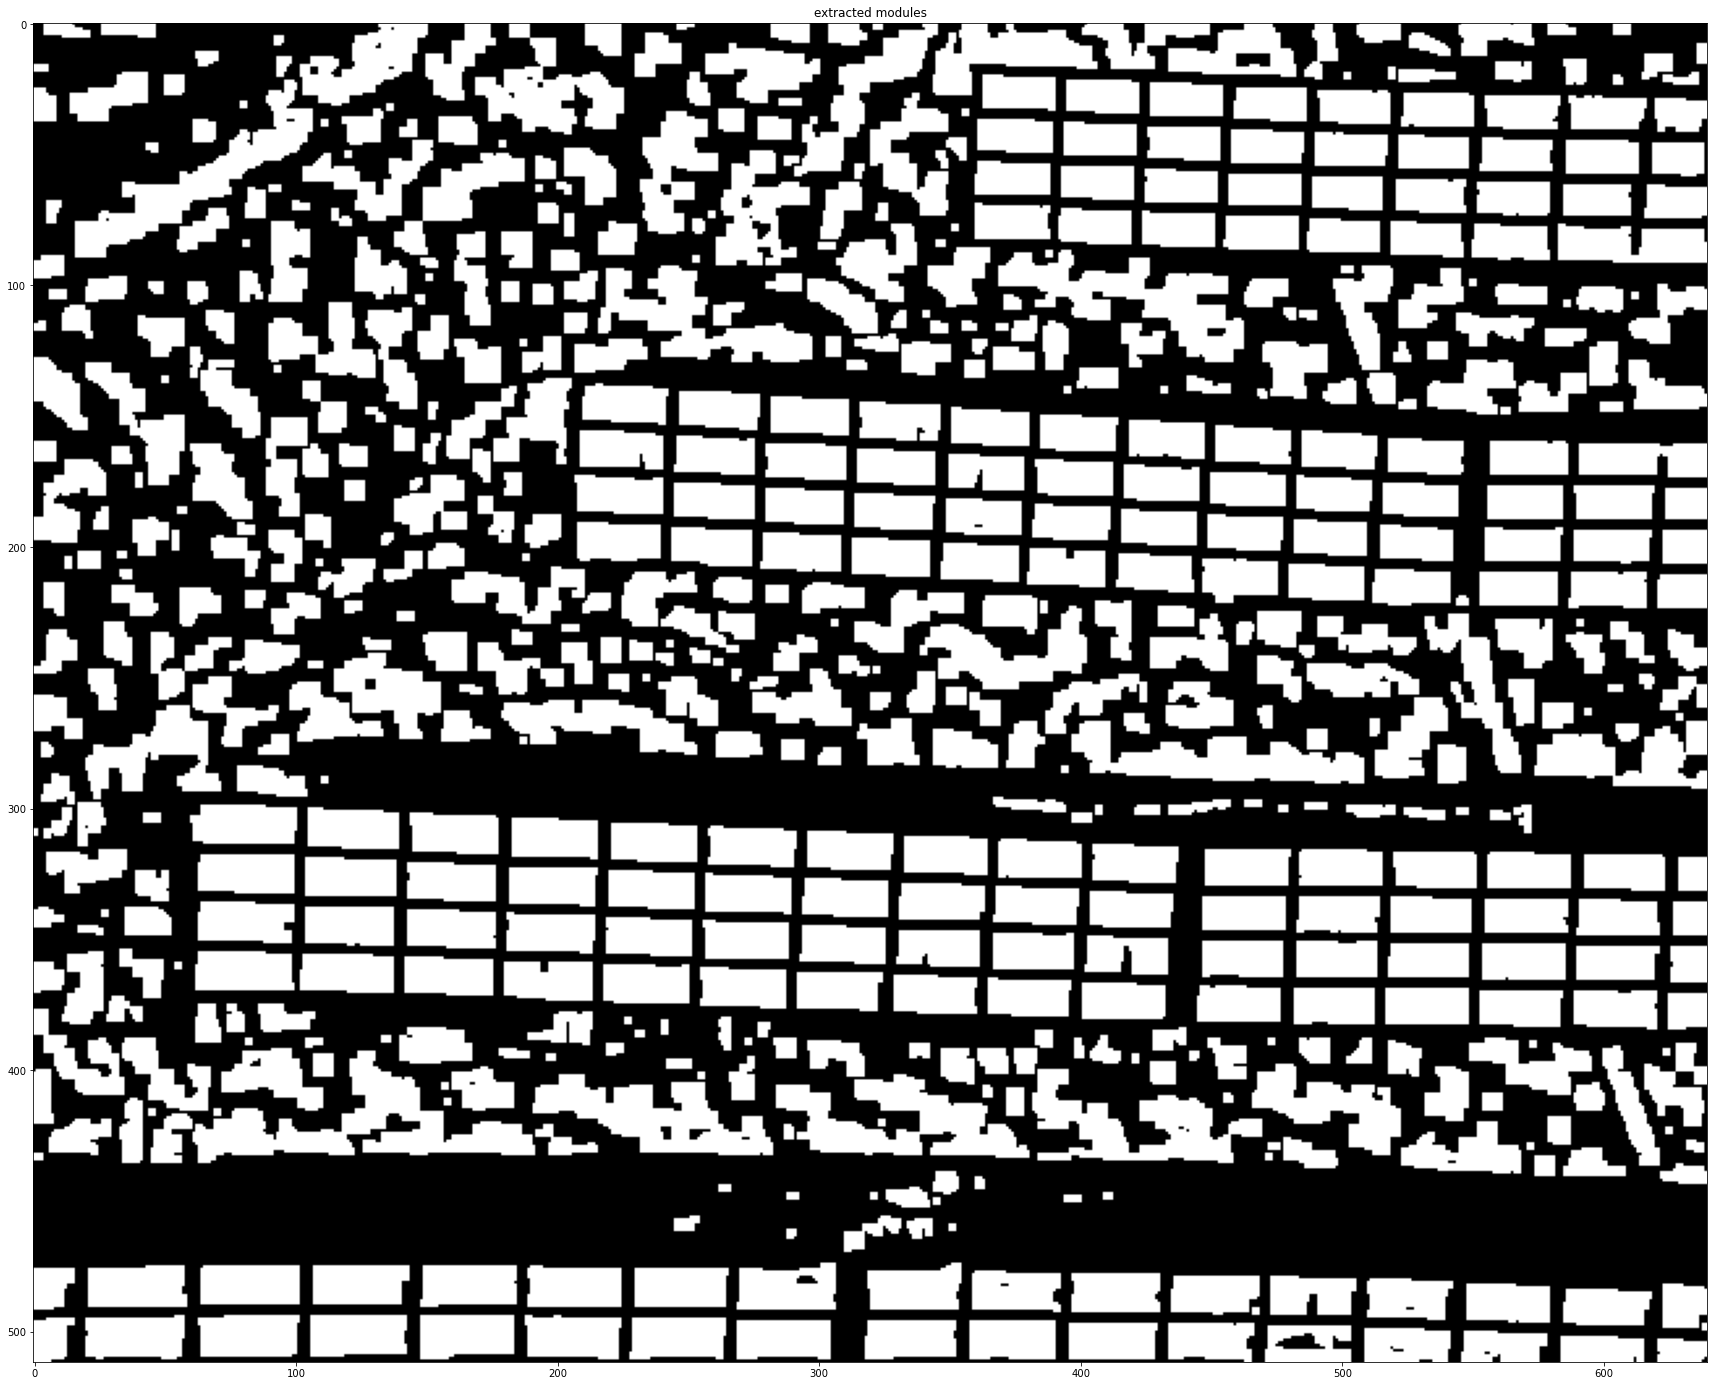

In [11]:
module_extraction.show_img({"extracted modules":img_filtered},cmap="gray",figsize=(30,30))

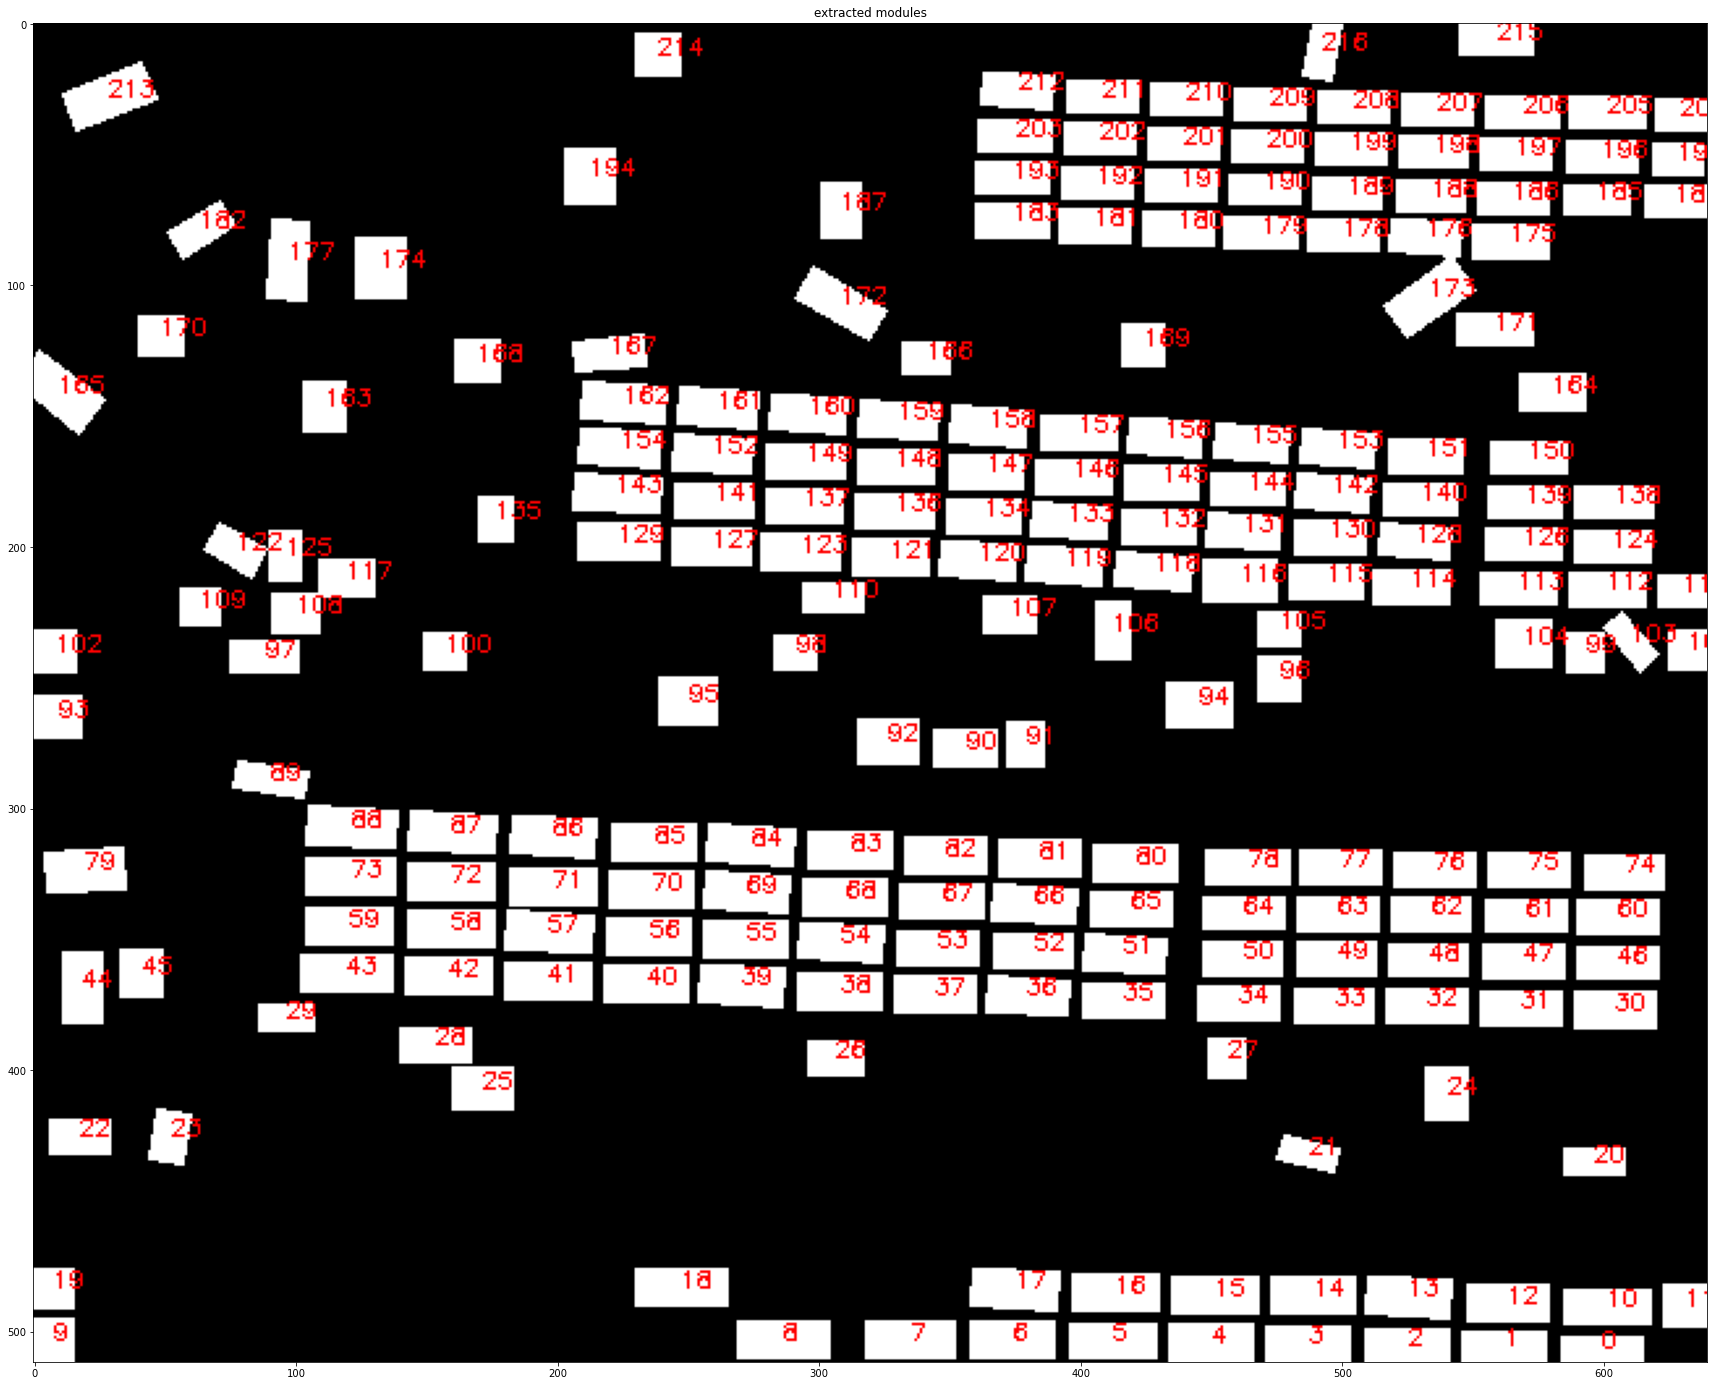

In [12]:
module_extraction.show_img({"extracted modules":img_con},cmap="gray",figsize=(30,30))

In [13]:
module_indices = list(map(lambda x: np.int(x.split(".")[0]), thermal_img_files.keys()))
module_contours = [modules.panel_contours[idx] for idx in module_indices]
module_labels = modules.get_string_anomaly_labels(module_contours)

(512.0, 0.0)

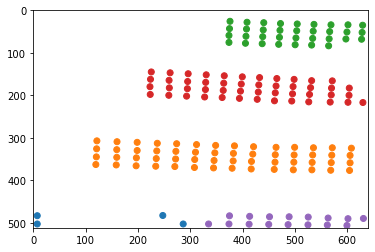

In [14]:
fig, ax = plt.subplots(facecolor="w")
cmap = plt.get_cmap("tab10")
module_centers = np.array( [c.mean(axis=0) for c in module_contours] )
plt.scatter(module_centers[:, 0], module_centers[:, 1], color=cmap(module_labels+1))
ax.set_xlim([0, img_con.shape[1]])
ax.set_ylim([img_con.shape[0], 0])

温度分布の確認

In [15]:
data = ThermalData(thermal_img_files, scale_type="individual")

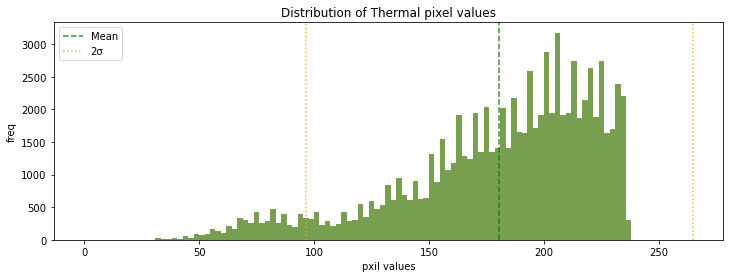

In [16]:
display.display_distributions(data.all_temperature, 
                              filepath = "hist_all_temperature.jpg")

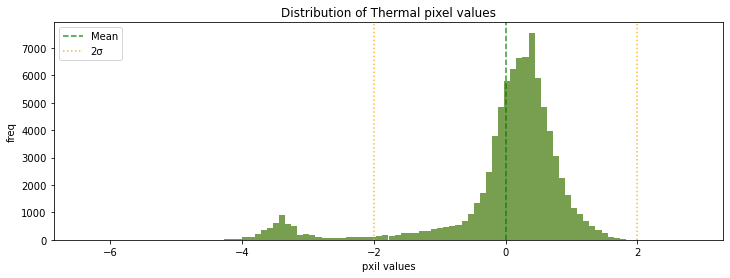

In [17]:
display.display_distributions(data.scaled_all_temperature,
                              filepath = "hist_scaled_all_temperature.jpg")

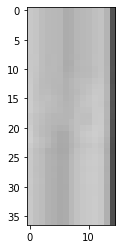

In [18]:
for k, v in list(thermal_img_files.items())[:1]:
    plt.imshow(v)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


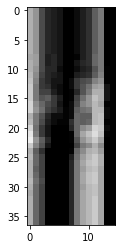

In [19]:
for k, v in list(thermal_img_files.items())[:1]:
    plt.imshow(data.scaled_temperature[k].reshape(v.shape))

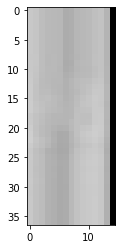

In [20]:
for k, v in list(thermal_img_files.items())[:1]:
    mask = (data.scaled_temperature[k] > -2).reshape(v.shape)
    plt.imshow(v * mask)

温度分布の確認（アレイごと）

In [21]:
from sklearn import preprocessing

In [22]:
# This will be implemented in ThermalData class
data_array = {}; array_scaler= {}; module_scaler = {}
for c in range(-1,max(module_labels)+1):
    indices = np.where(module_labels==c)
    target_thermal_img_files = pd.Series(thermal_img_files).iloc[indices]
    data_array[c] = ThermalData(target_thermal_img_files, scale_type="individual")
    # -- original temperature --
    temperature = {
        k: v.reshape(-1,v.shape[2]) for k, v in target_thermal_img_files.items()        
    }
    all_temperature = np.concatenate([*temperature.values()])
    # -- array scaler for anomaly detection --
    pscaler = preprocessing.PowerTransformer(standardize=True)        
    array_scaler[c] = pscaler.fit(data_array[c].all_temperature)        
    # -- scaled temperature (z-value) --
    sscaler = preprocessing.StandardScaler()
    scaled_temperature = {
        k: sscaler.fit_transform(v.reshape(-1,v.shape[2])) for k, v in target_thermal_img_files.items()         
    }
    scaled_all_temperature = np.concatenate([*scaled_temperature.values()])
    # -- masked temperature (excluding shade) -- 
    masked_temperature = {
        k: temperature[k][(v>-2) & (v< 2)].reshape(-1, v.shape[1]) for k, v in scaled_temperature.items()
    }
    masked_all_temperature = np.concatenate([*masked_temperature.values()])

module label: -1


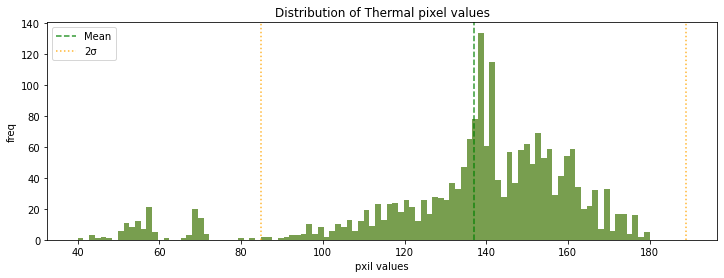

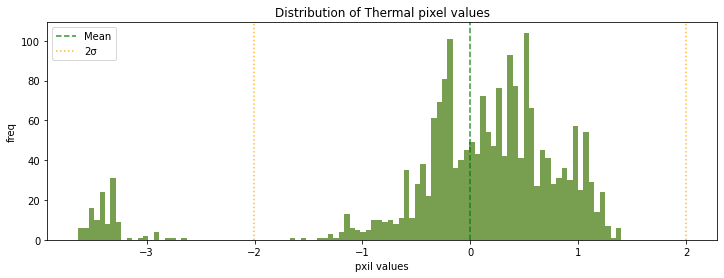

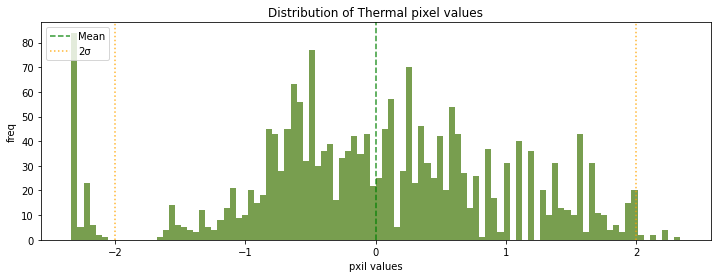

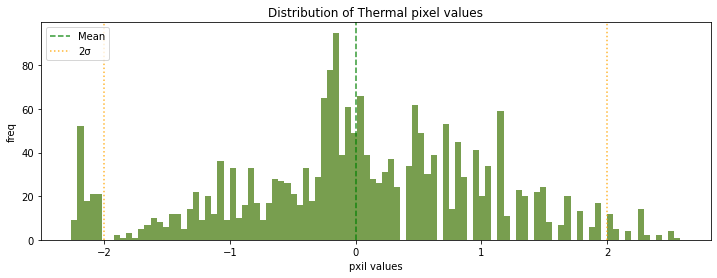

module label: 0


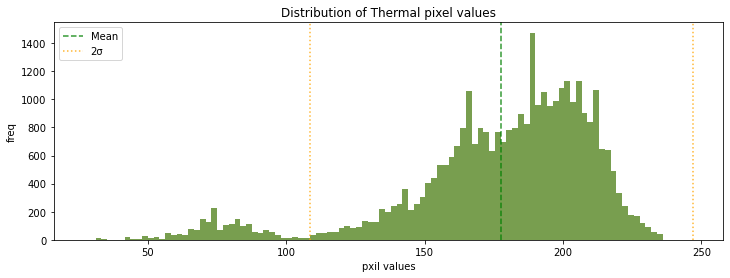

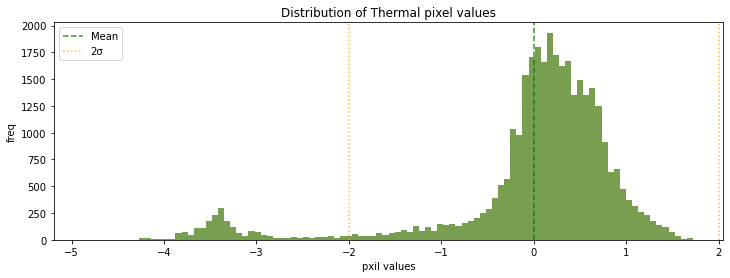

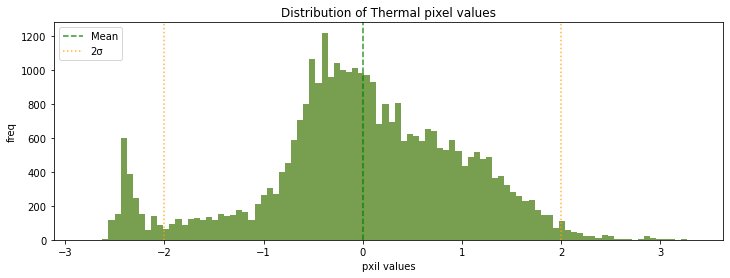

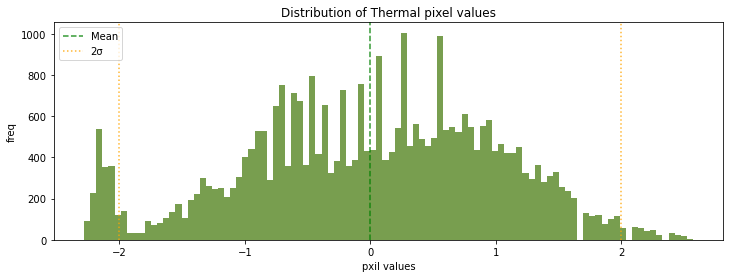

module label: 1


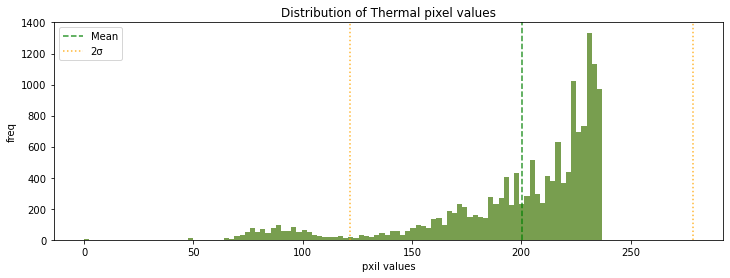

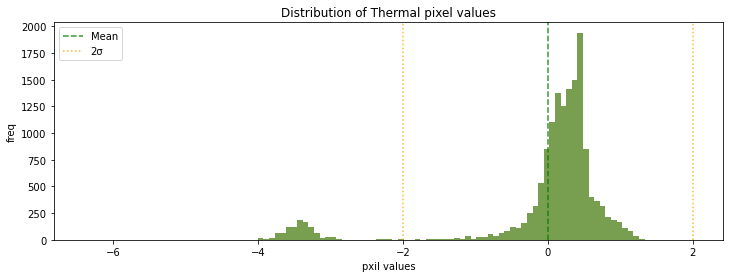

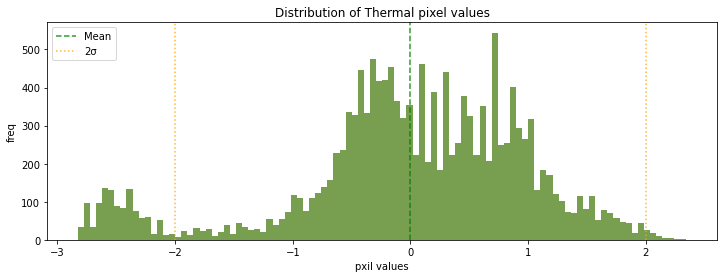

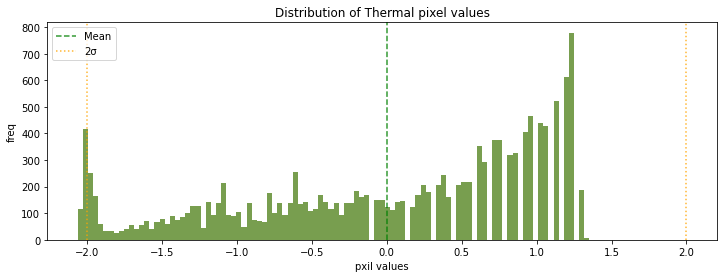

module label: 2


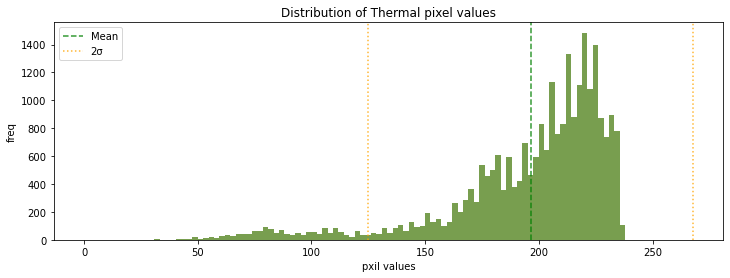

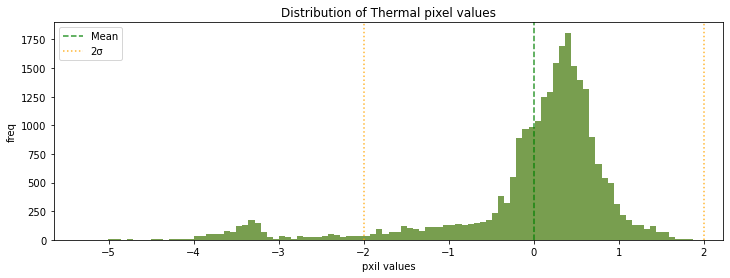

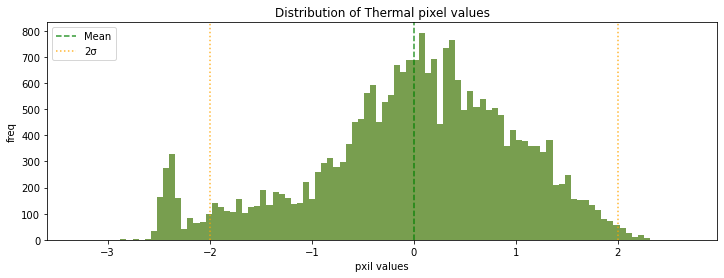

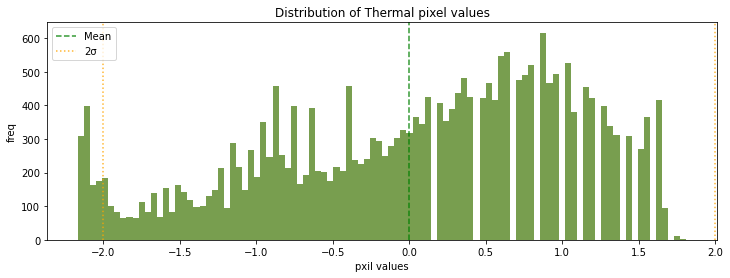

module label: 3


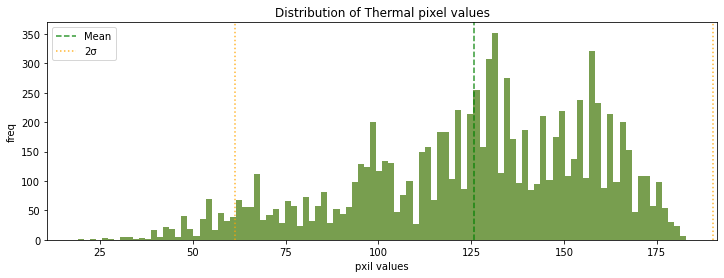

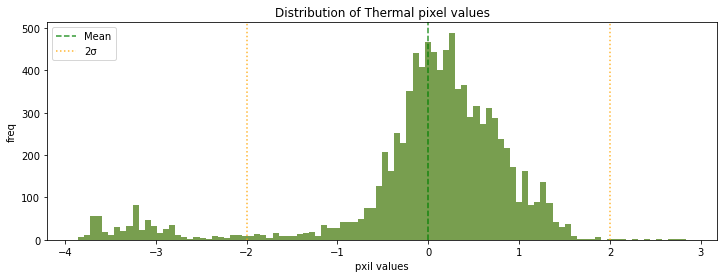

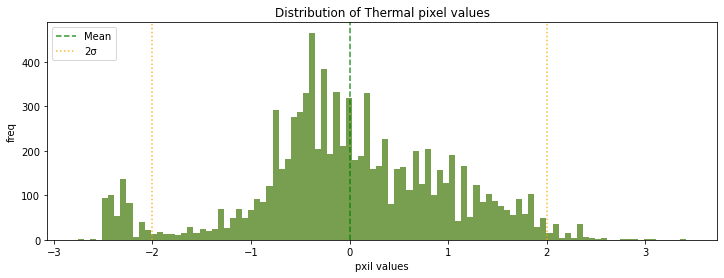

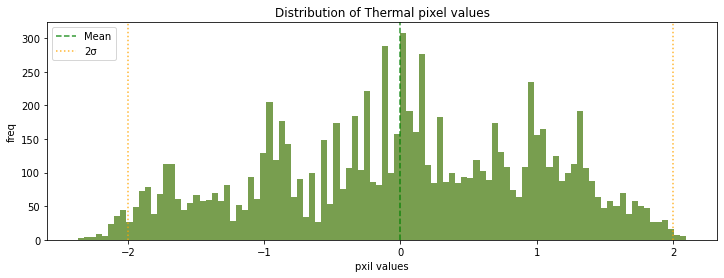

In [23]:
for k, v in data_array.items():
    print("module label:",k)
    display.display_distributions(v.all_temperature, 
                              filepath = "hist_all_temperature.jpg")
    display.display_distributions(v.scaled_all_temperature, 
                              filepath = "hist_scaled_all_temperature.jpg")        
    display.display_distributions(v.transformed_all_temperature, 
                              filepath = "hist_transformed_all_temperature.jpg")        
    display.display_distributions(array_scaler[k].transform(v.all_temperature), 
                              filepath = "hist_transformed_all_temperature.jpg")

異常タイプの確認テスト

In [24]:
def get_hotspots_in_array(clusters_temperature, array_id, img_file, log=False):
    # -- hot cluster --
    transformed_temperature = array_scaler[array_id].transform(clusters_temperature).mean(axis=1)
    hot_clusters = (transformed_temperature > 1.5)
    # -- hot pixcel --
    hot_pixels = np.array([c in np.where(hot_clusters==True)[0] for c in clusters.labels])
    hot_pixels = hot_pixels.reshape(*img_file.shape[:2],1)      
    if log:
        print("Hot cluster labels in array:",hot_clusters)
        print("Hotspot weights in array:",hot_pixels.mean())
    return hot_pixels, hot_clusters

In [25]:
def get_hotspots_in_module(scaled_clusters_temperature,  img_file, log=False):
    # -- hot cluster --
    hot_clusters = (scaled_clusters_temperature.mean(axis=1) > 1.0)
    # -- hot pixcel --
    hot_pixels = np.array([c in np.where(hot_clusters==True)[0] for c in clusters.labels])
    hot_pixels = hot_pixels.reshape(*img_file.shape[:2],1)      
    if log:
        print("Hot cluster labels in module:",hot_clusters)
        print("Hotspot weights in module:",hot_pixels.mean())
    return hot_pixels, hot_clusters

In [26]:
anomaly_modules= {}
clustering_method="kmeans"
#clustering_method="xmeans" # not stable
#clustering_method="dbscan"

******* start *******
63.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


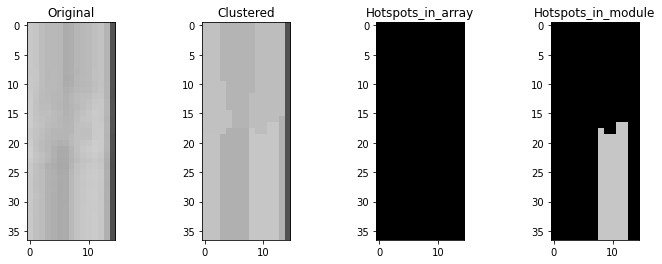

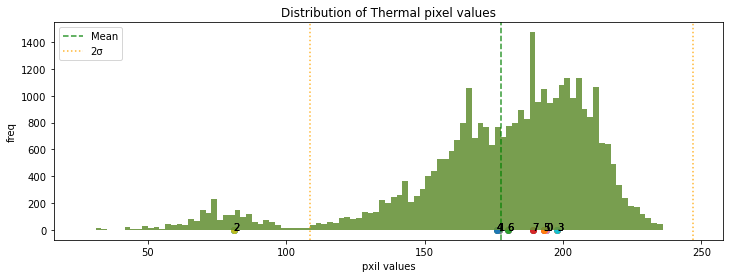

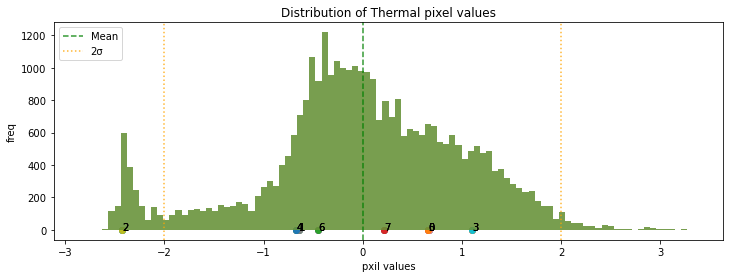

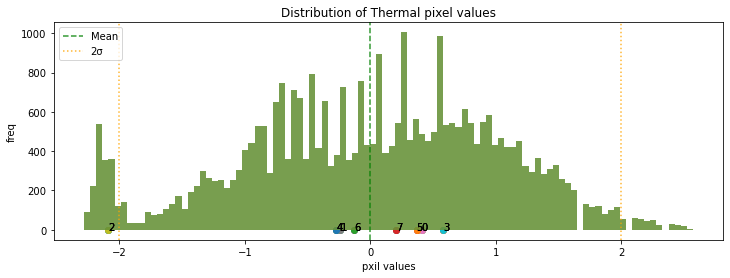

******* end *******
******* start *******
189.jpg
Module type_in_array: Normal
Module type_in_module: Normal


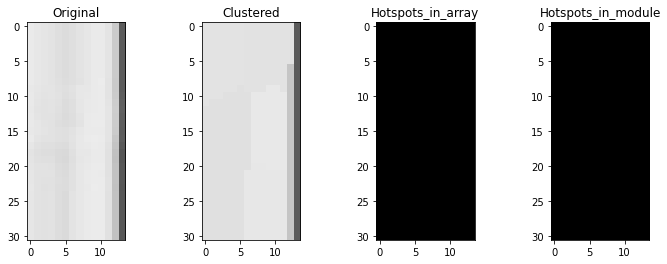

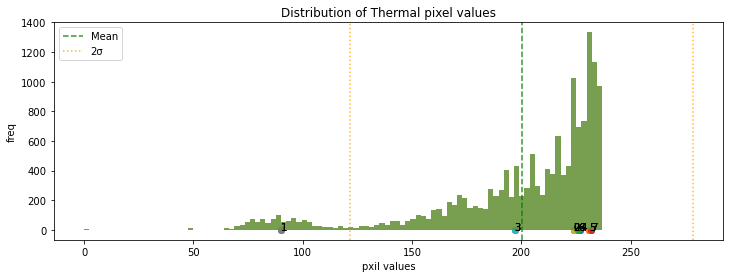

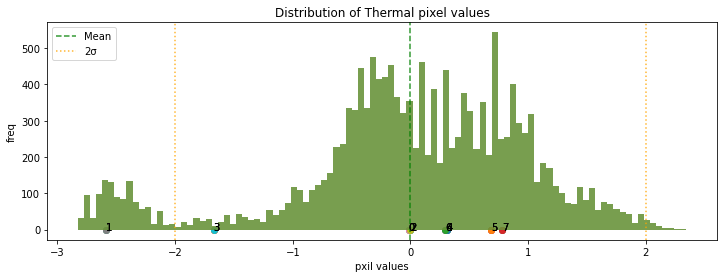

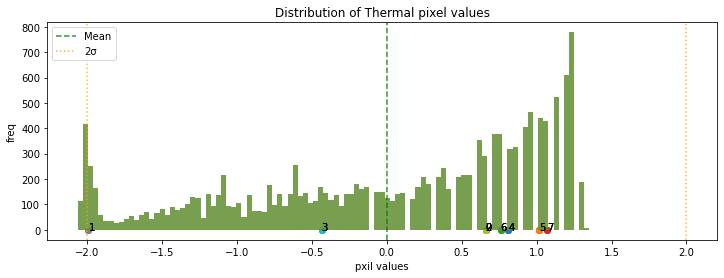

******* end *******
******* start *******
77.jpg
Module type_in_array: Normal
Module type_in_module: Multi-Hotspots


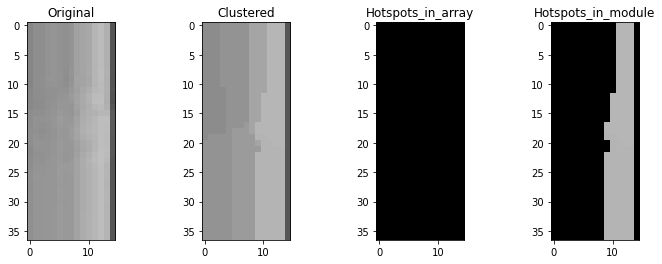

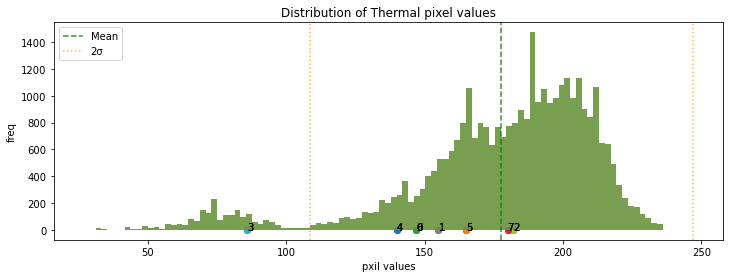

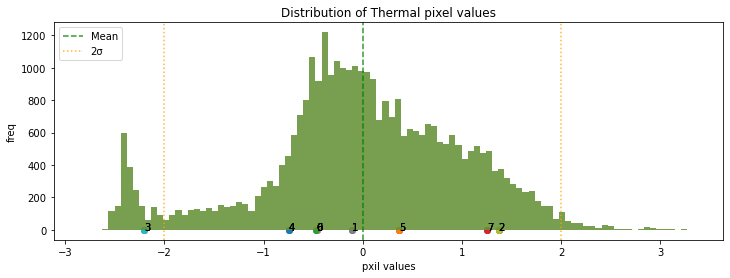

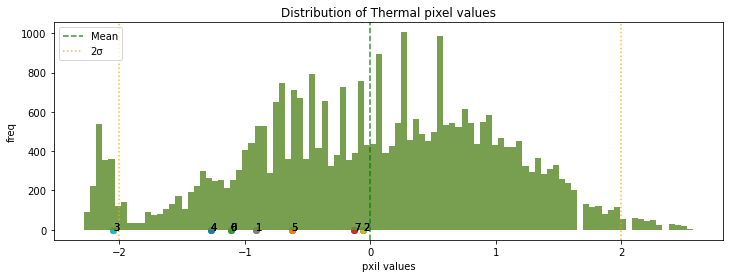

******* end *******
******* start *******
162.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


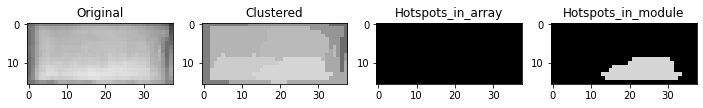

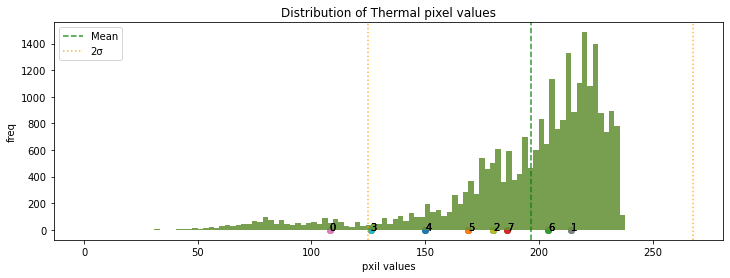

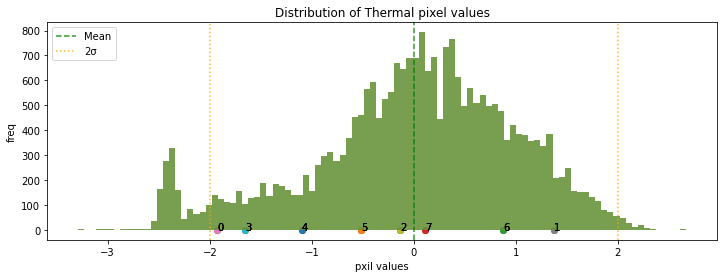

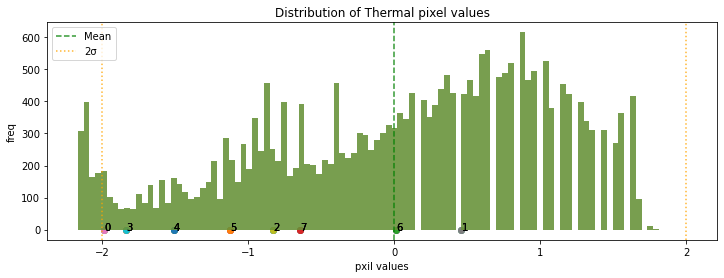

******* end *******
******* start *******
176.jpg
Module type_in_array: Normal
Module type_in_module: Normal


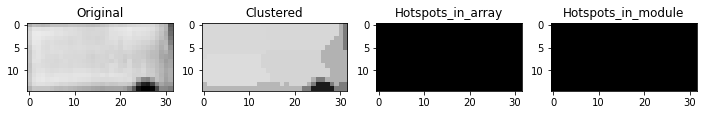

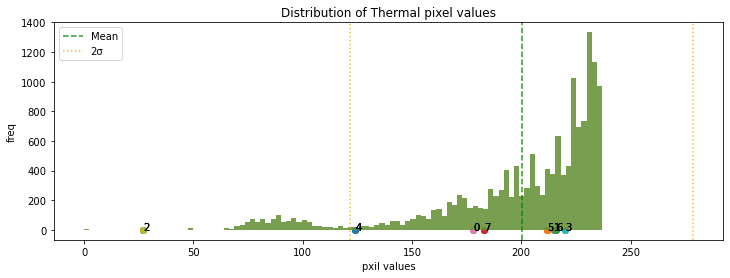

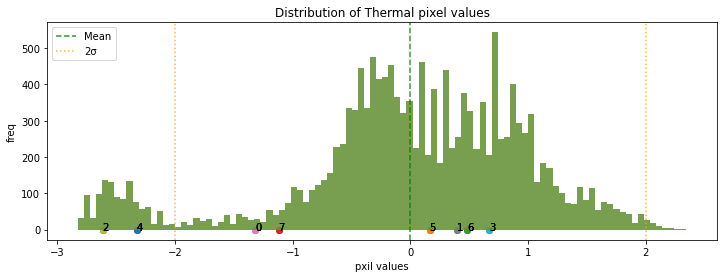

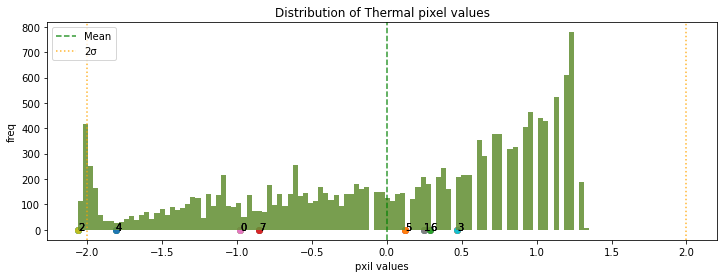

******* end *******
******* start *******
88.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


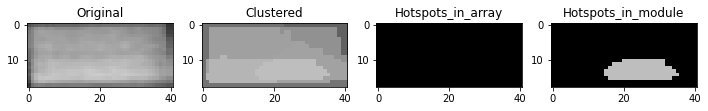

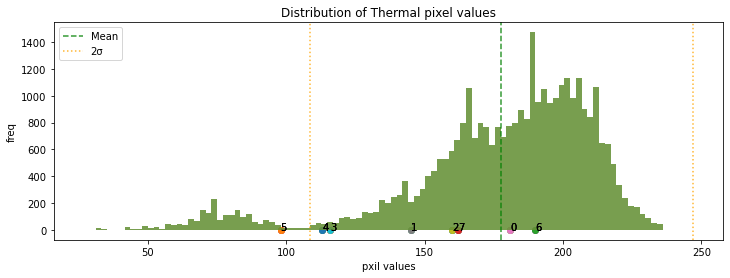

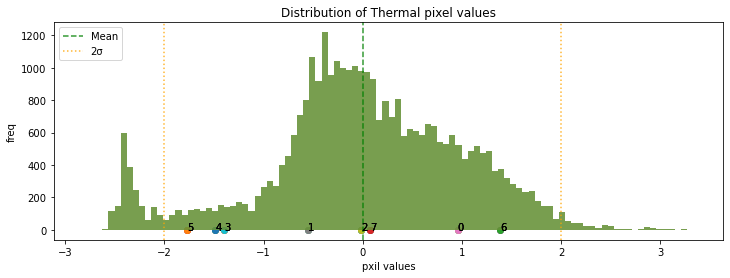

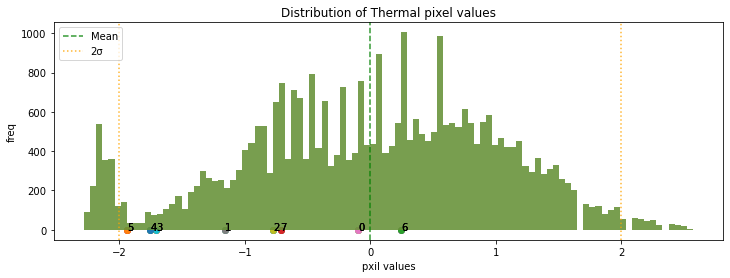

******* end *******
******* start *******
200.jpg
Module type_in_array: Normal
Module type_in_module: Normal


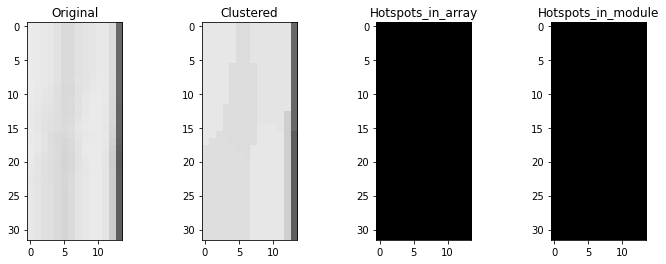

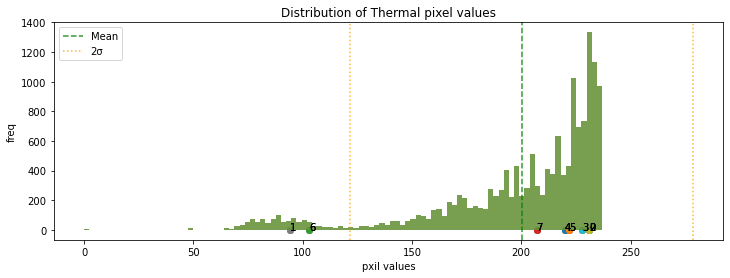

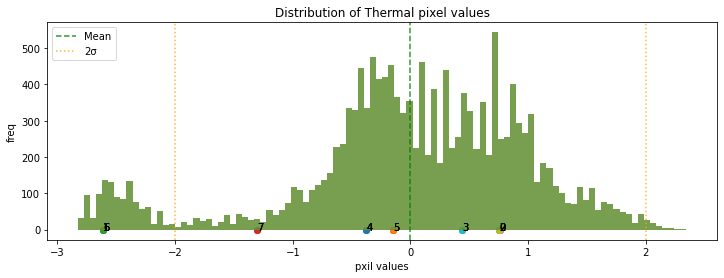

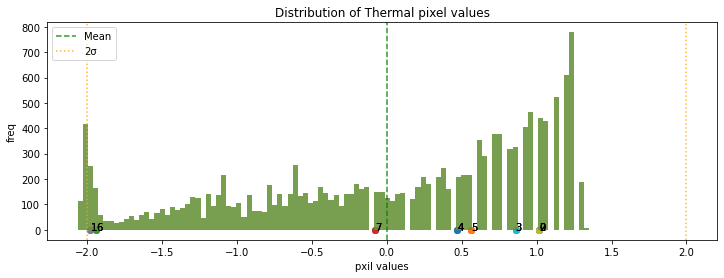

******* end *******
******* start *******
201.jpg
Module type_in_array: Normal
Module type_in_module: Normal


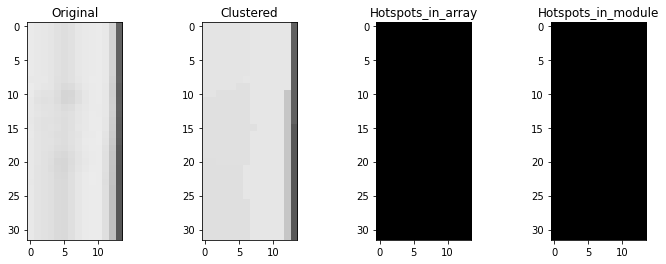

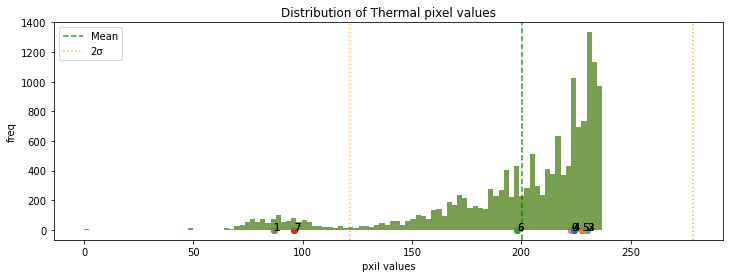

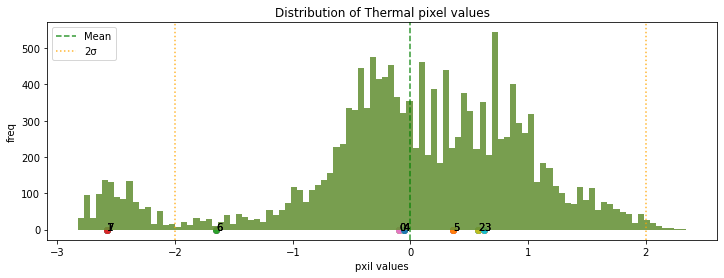

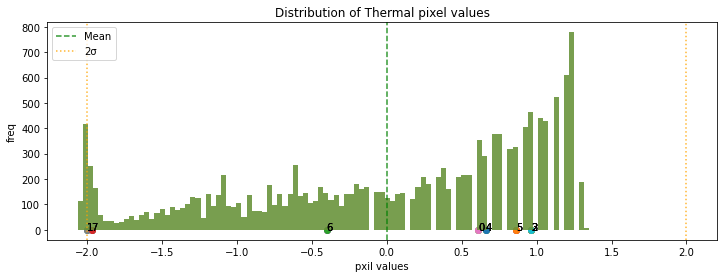

******* end *******
******* start *******
188.jpg
Module type_in_array: Normal
Module type_in_module: Normal


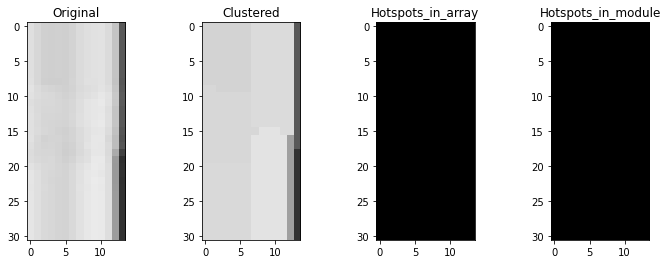

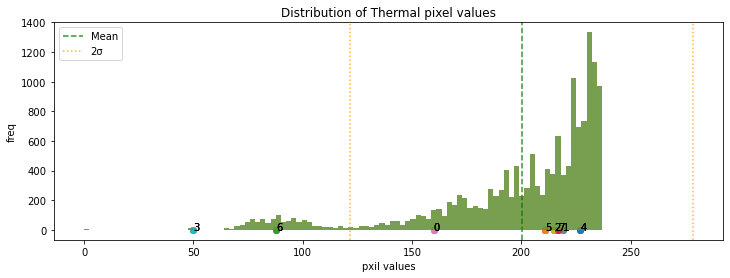

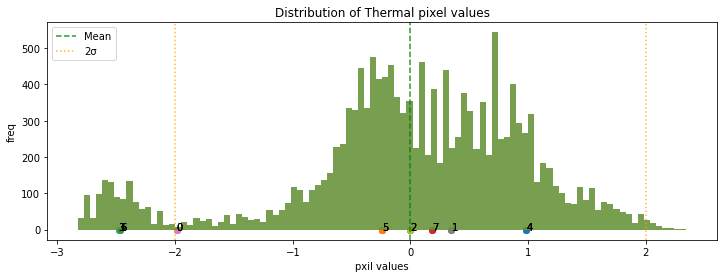

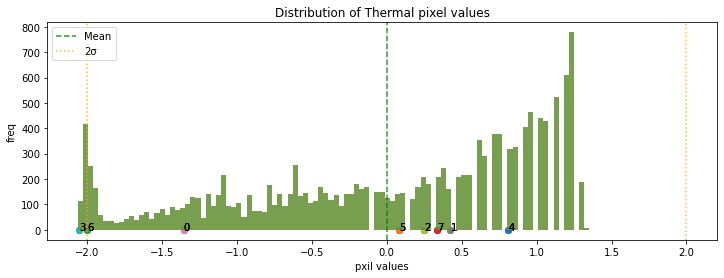

******* end *******
******* start *******
76.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


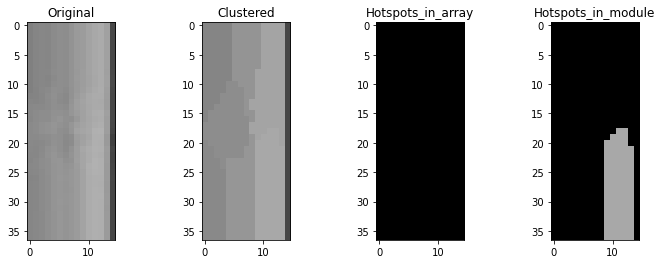

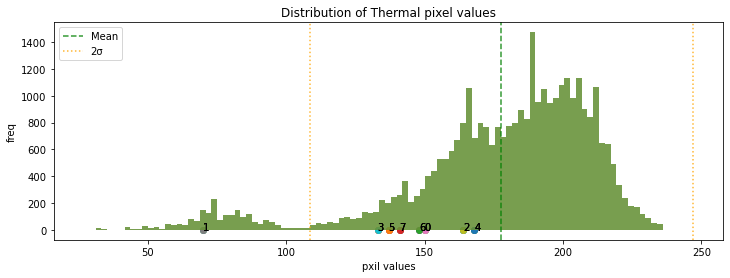

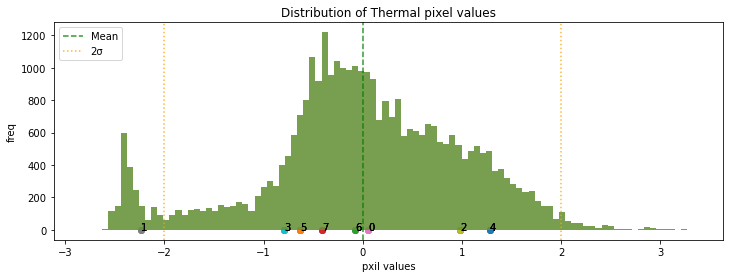

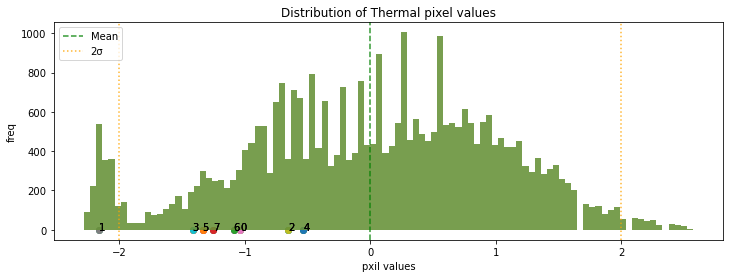

******* end *******
******* start *******
62.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


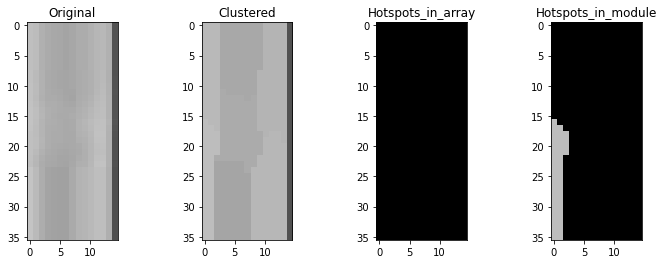

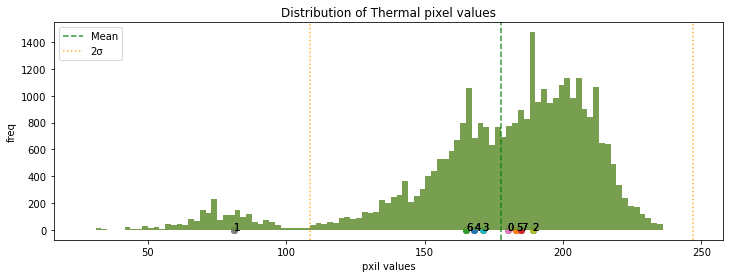

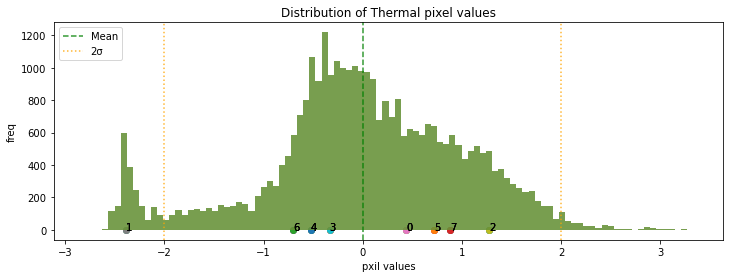

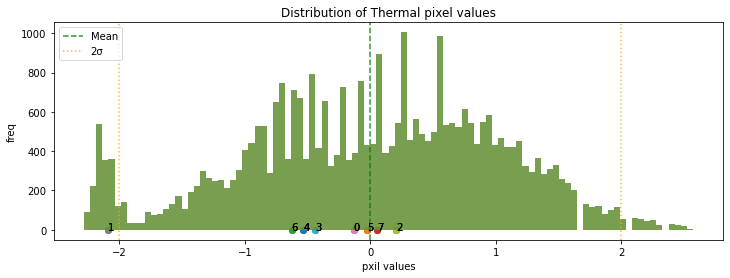

******* end *******
******* start *******
74.jpg
Module type_in_array: Normal
Module type_in_module: Multi-Hotspots


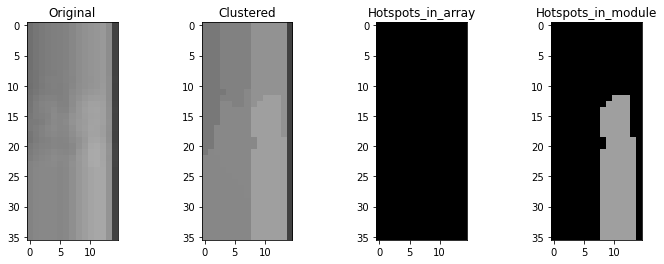

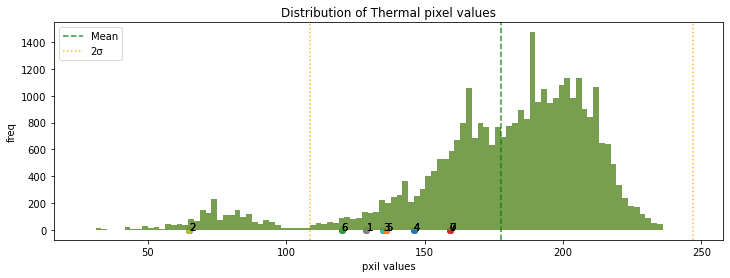

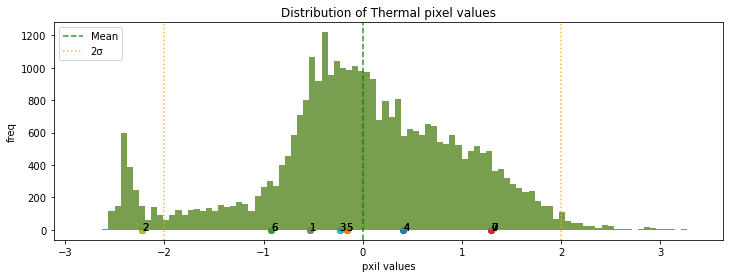

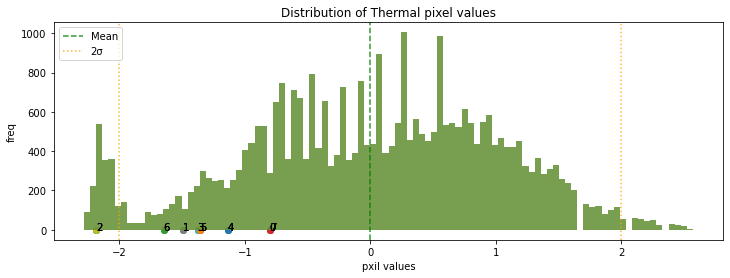

******* end *******
******* start *******
60.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


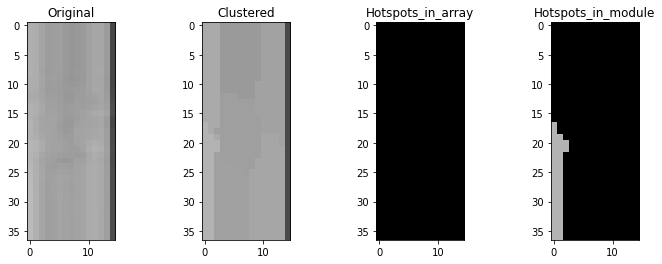

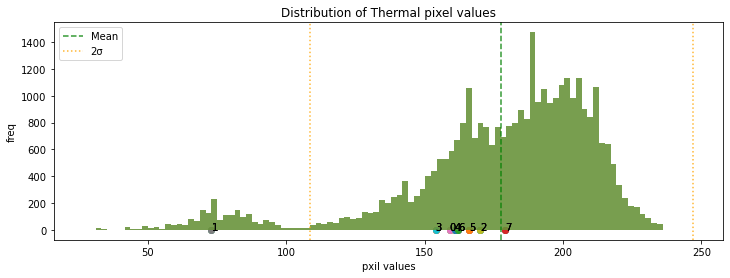

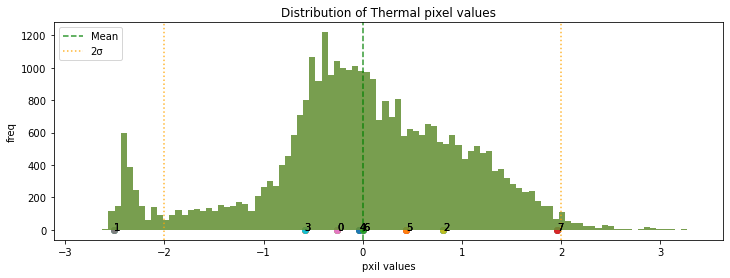

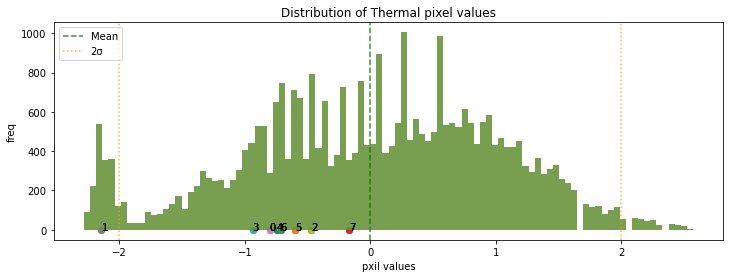

******* end *******
******* start *******
48.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


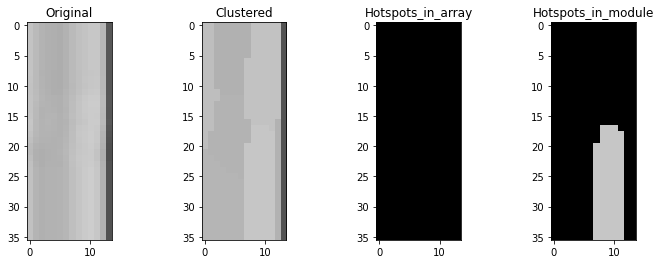

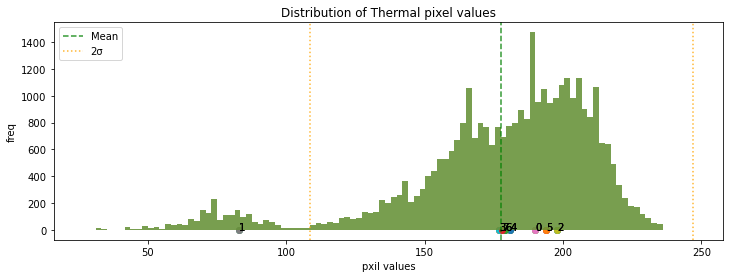

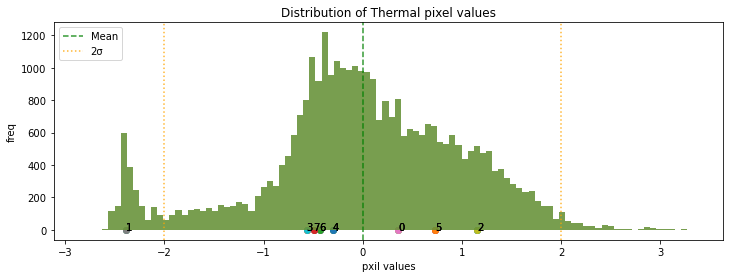

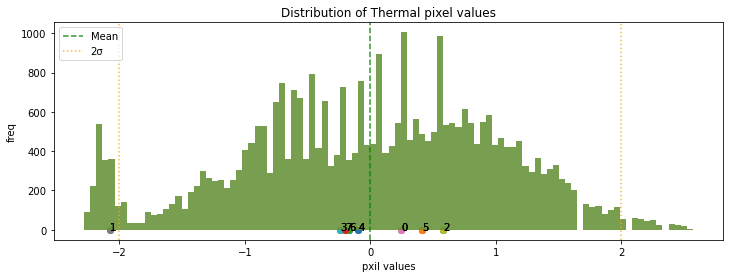

******* end *******
******* start *******
149.jpg
Module type_in_array: Normal
Module type_in_module: Multi-Hotspots


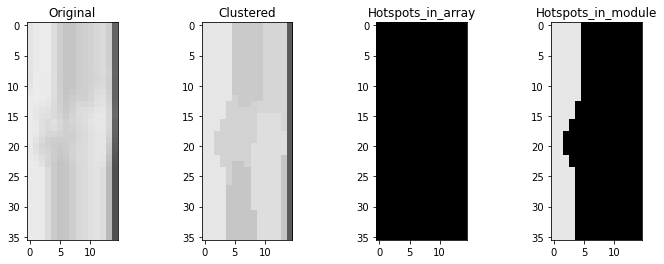

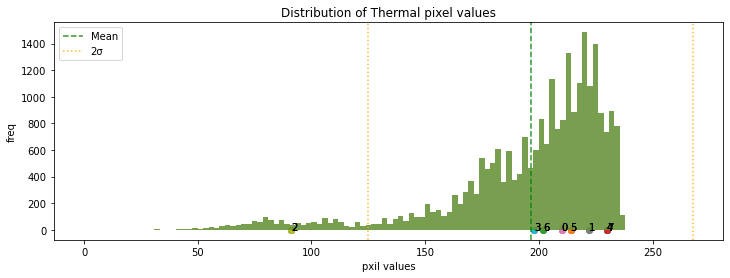

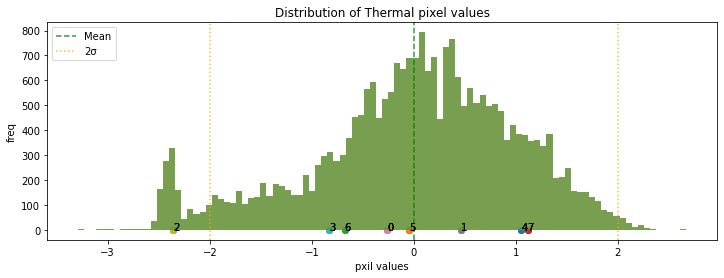

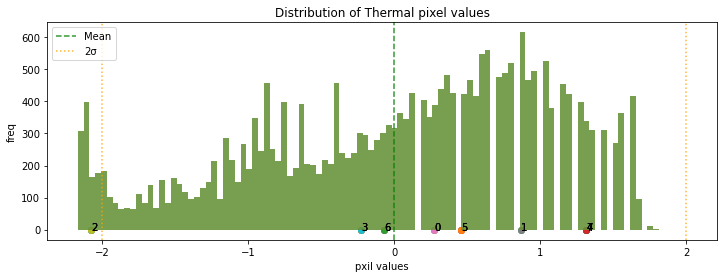

******* end *******
******* start *******
175.jpg
Module type_in_array: Normal
Module type_in_module: Multi-Hotspots


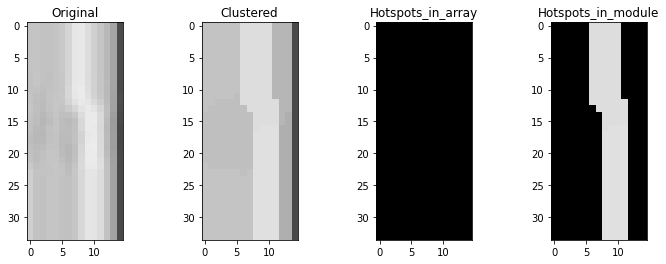

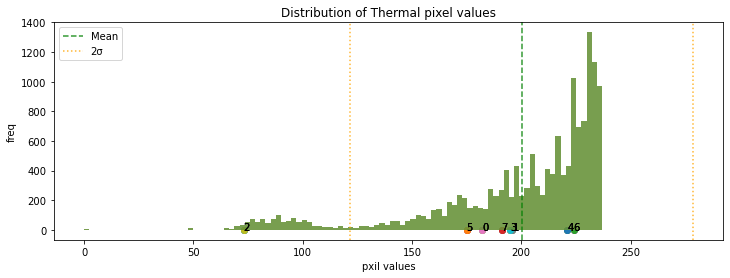

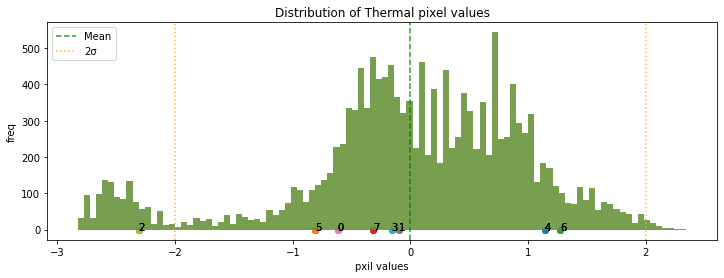

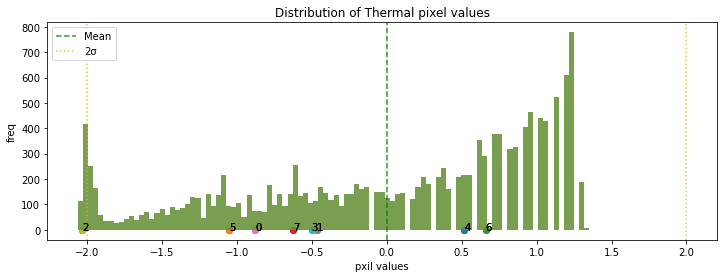

******* end *******
******* start *******
161.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


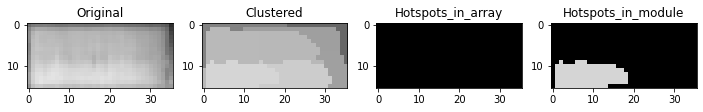

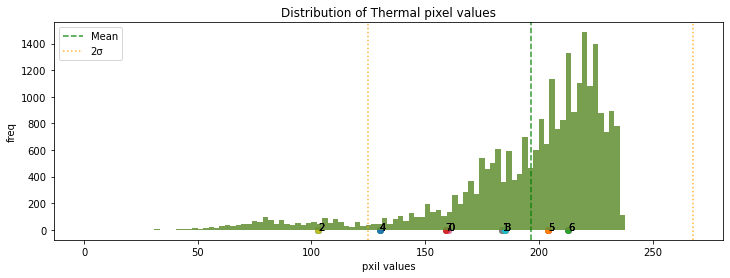

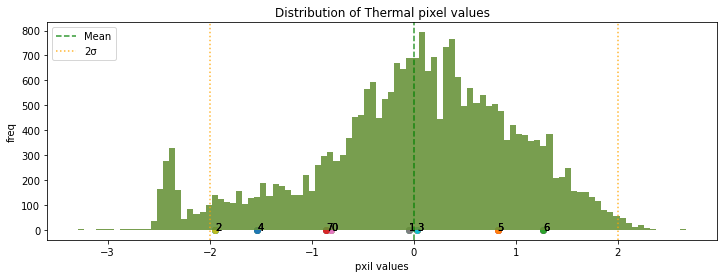

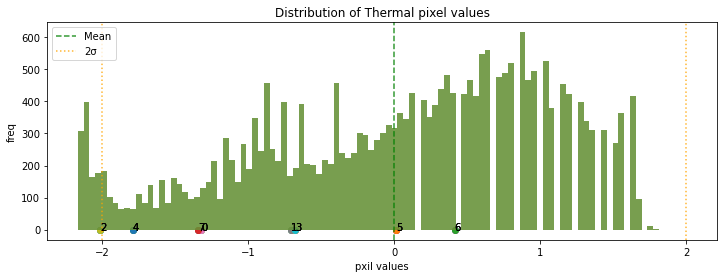

******* end *******
******* start *******
203.jpg
Module type_in_array: Normal
Module type_in_module: Normal


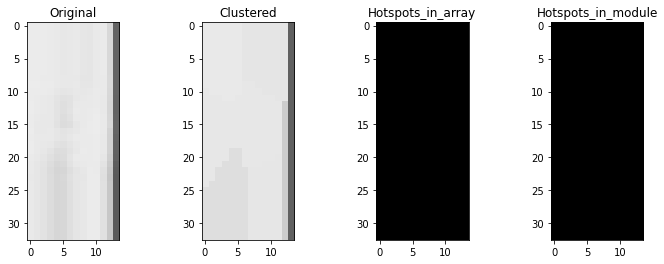

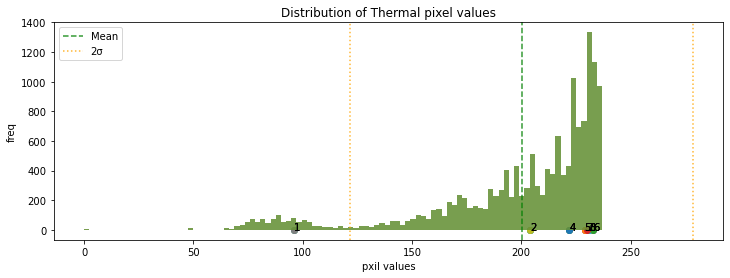

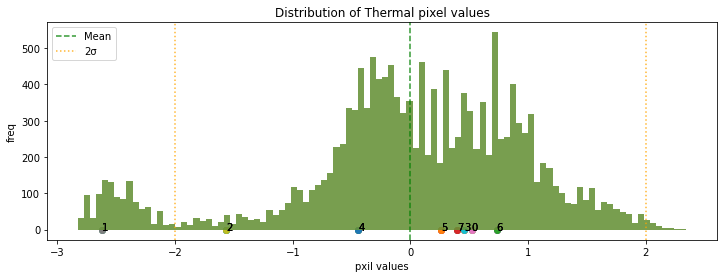

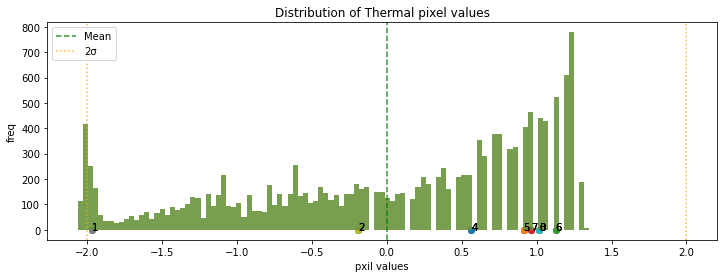

******* end *******
******* start *******
202.jpg
Module type_in_array: Normal
Module type_in_module: Normal


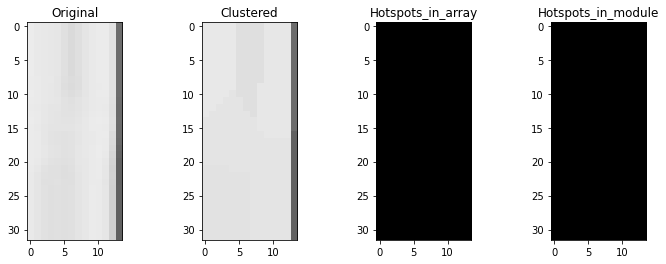

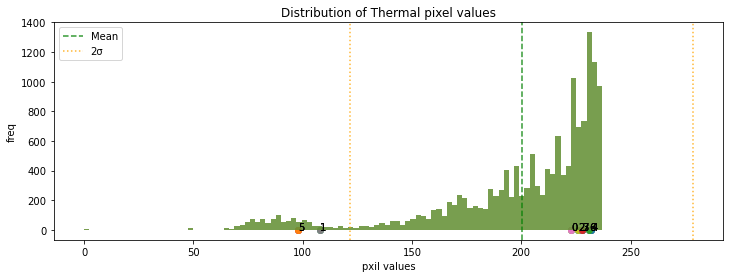

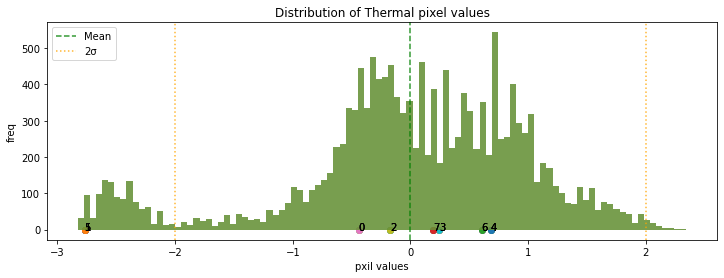

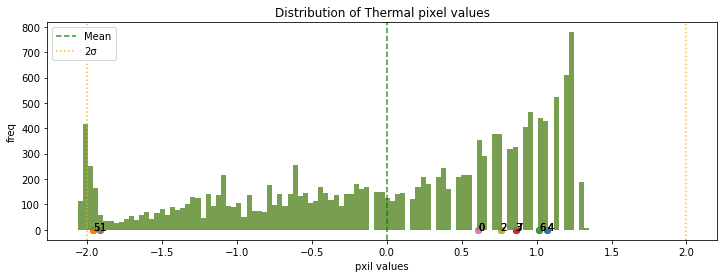

******* end *******
******* start *******
160.jpg
Module type_in_array: Normal
Module type_in_module: Multi-Hotspots


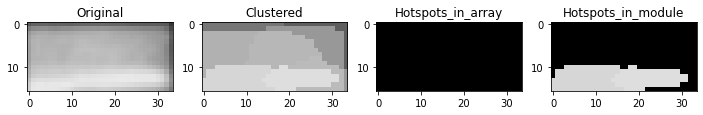

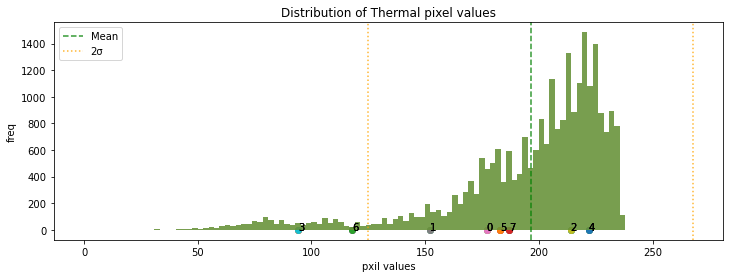

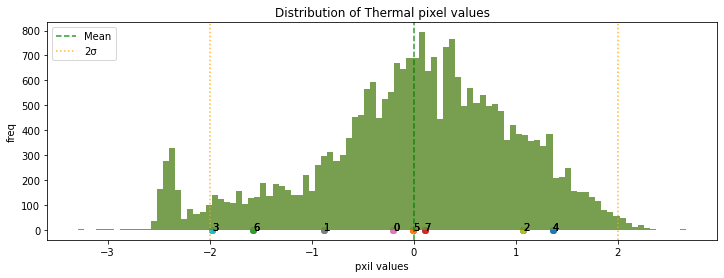

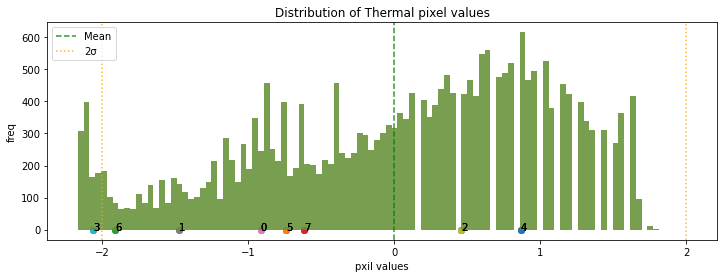

******* end *******
******* start *******
148.jpg
Module type_in_array: Normal
Module type_in_module: Normal


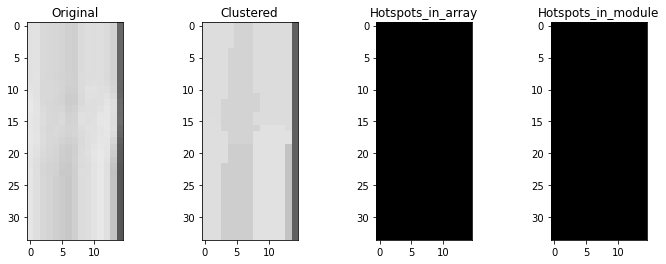

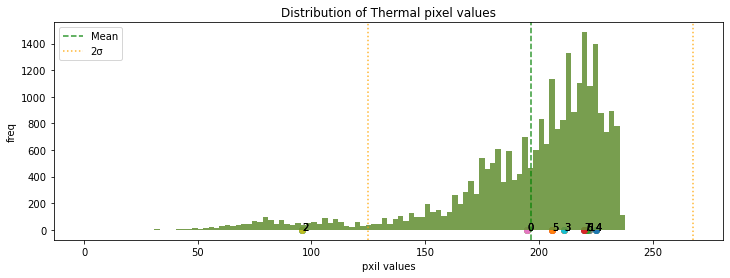

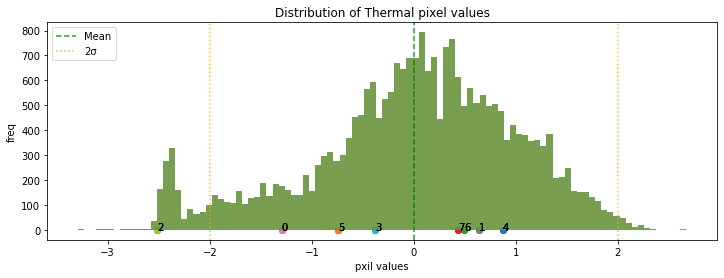

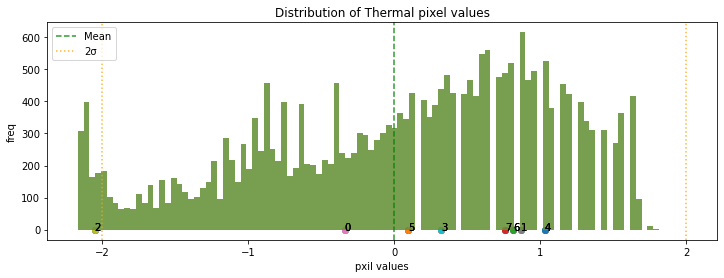

******* end *******
******* start *******
49.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


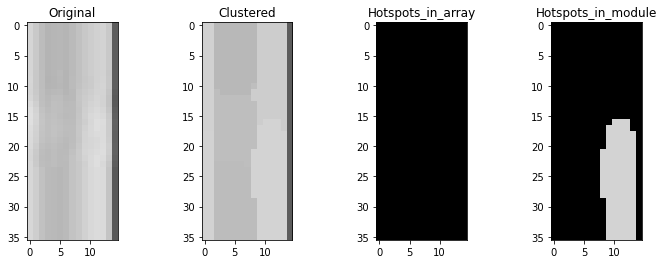

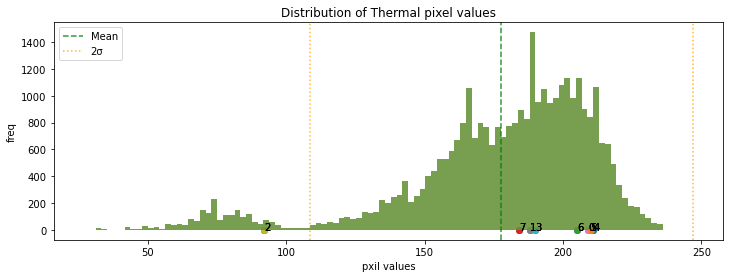

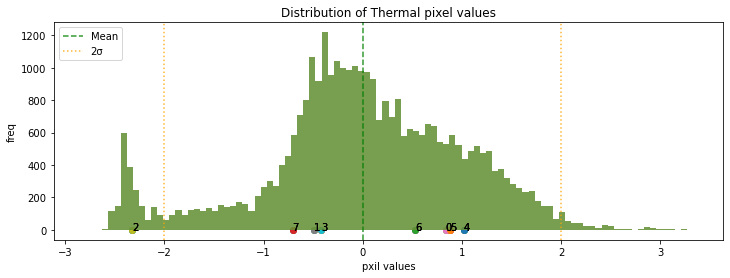

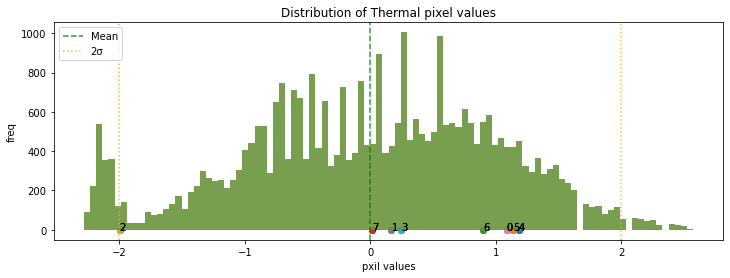

******* end *******
******* start *******
61.jpg
Module type_in_array: Normal
Module type_in_module: Normal


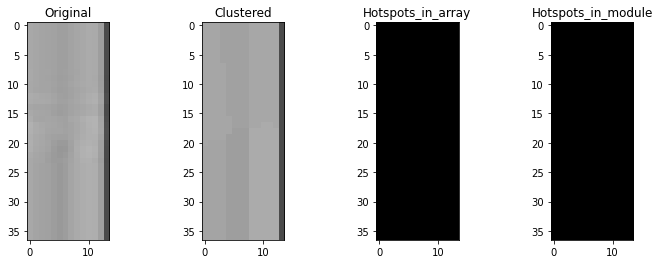

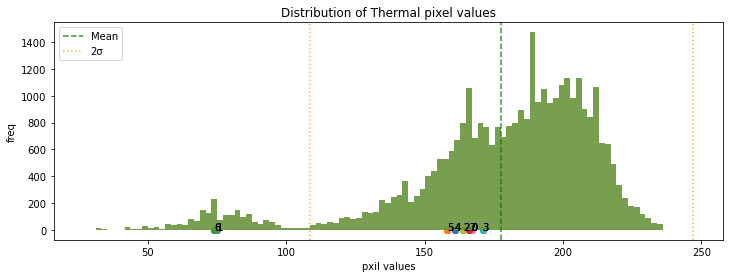

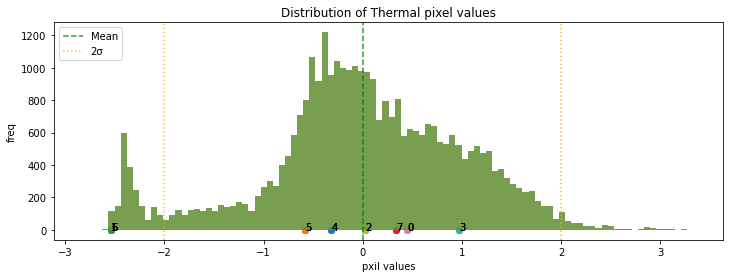

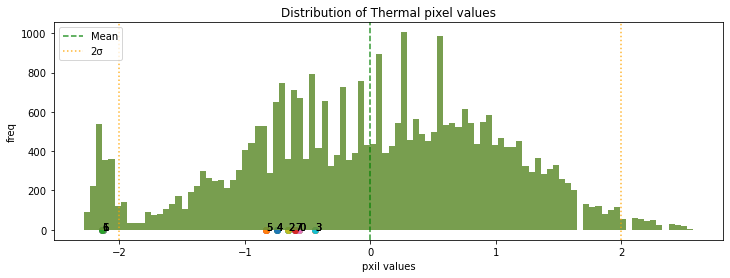

******* end *******
******* start *******
75.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


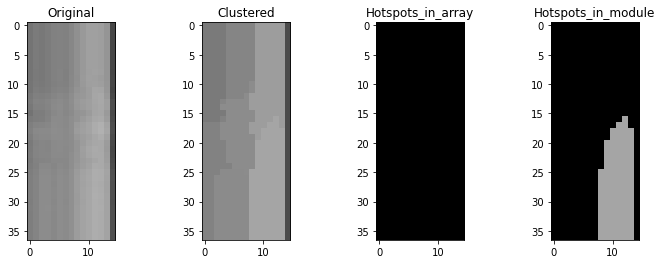

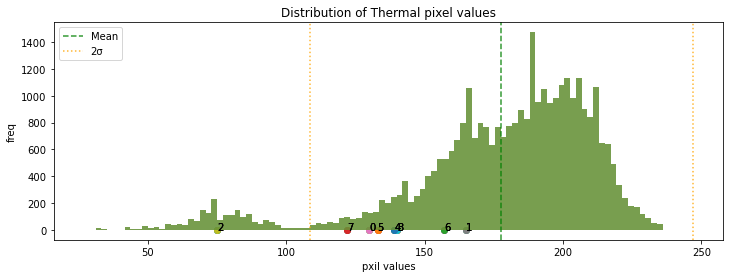

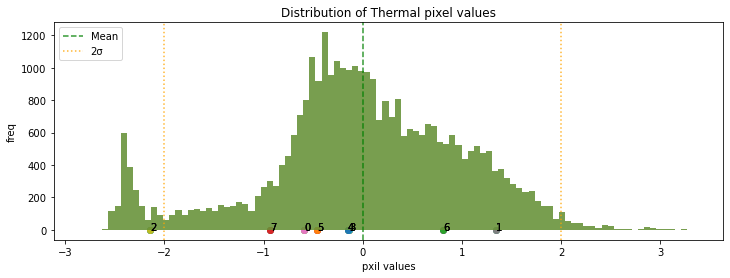

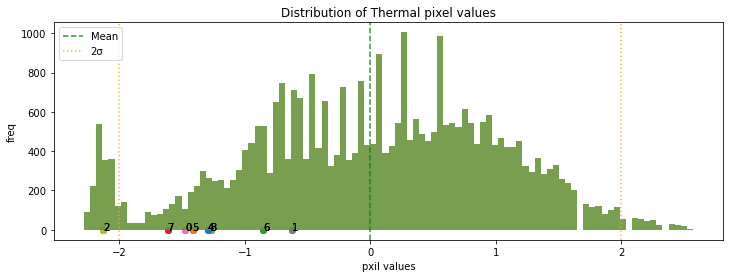

******* end *******
******* start *******
59.jpg
Module type_in_array: Normal
Module type_in_module: Normal


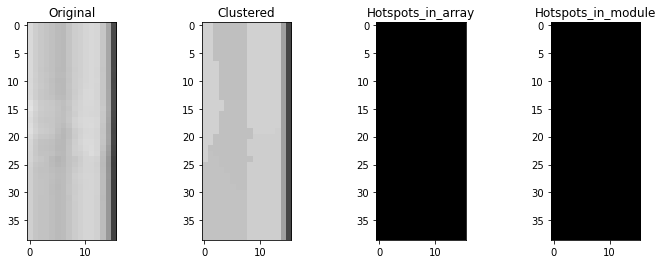

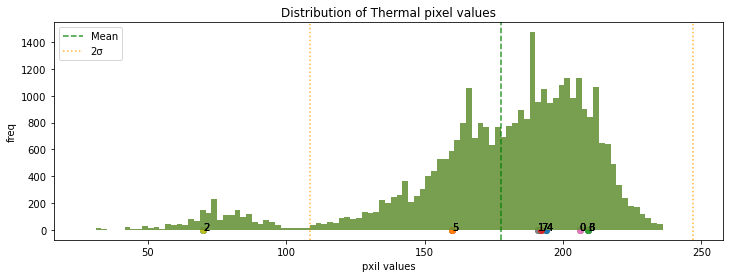

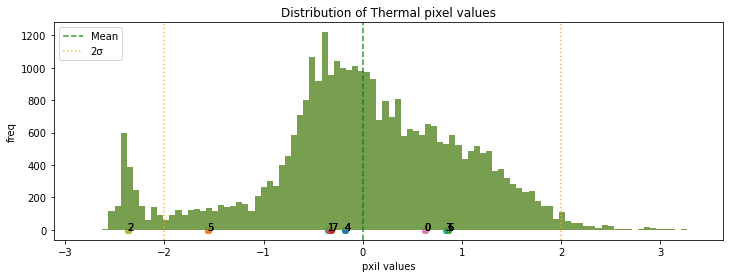

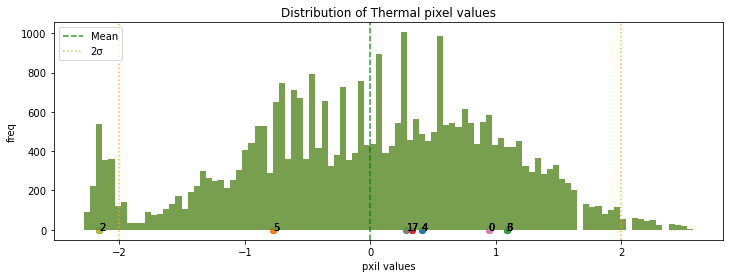

******* end *******
******* start *******
71.jpg
Module type_in_array: Normal
Module type_in_module: Normal


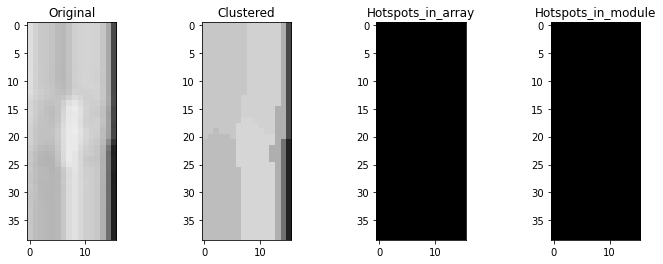

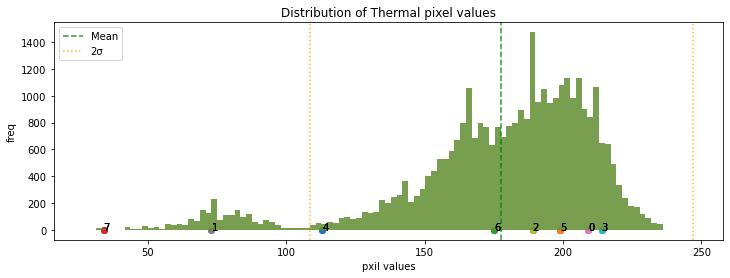

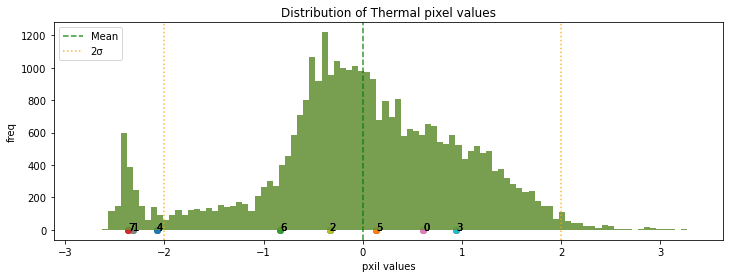

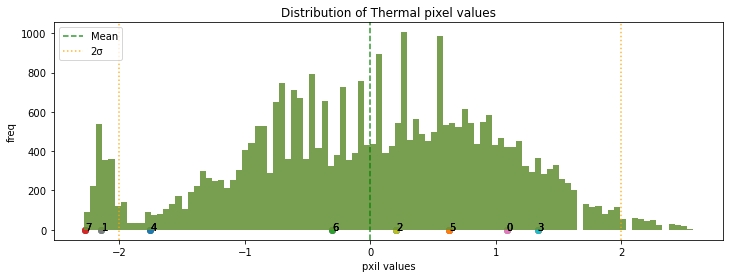

******* end *******
******* start *******
65.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


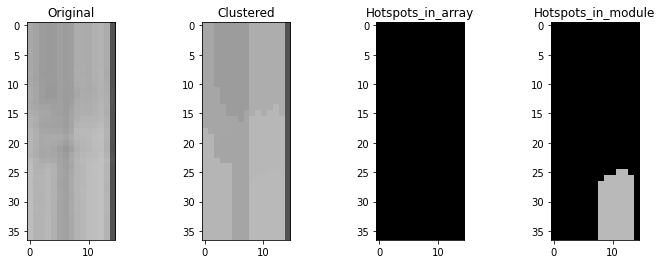

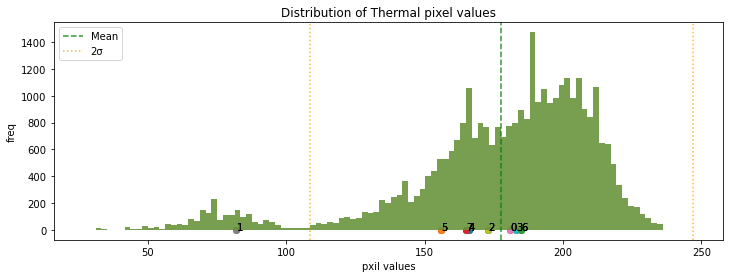

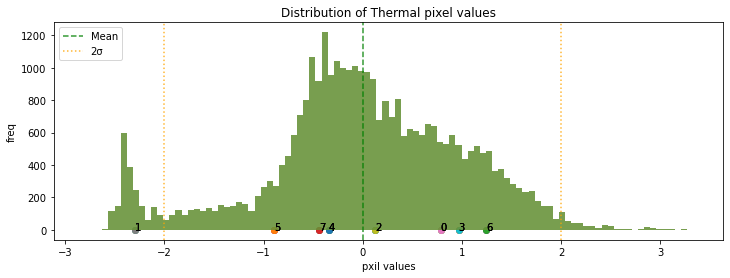

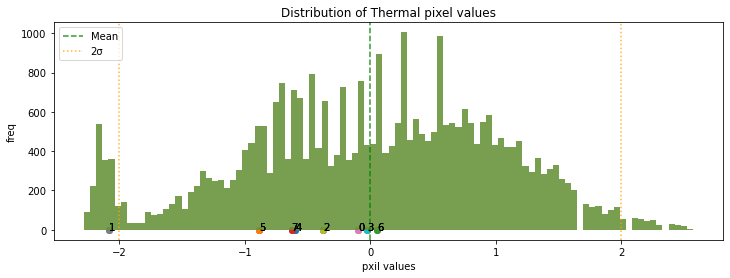

******* end *******
******* start *******
158.jpg
Module type_in_array: Normal
Module type_in_module: Multi-Hotspots


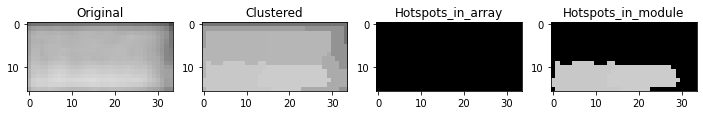

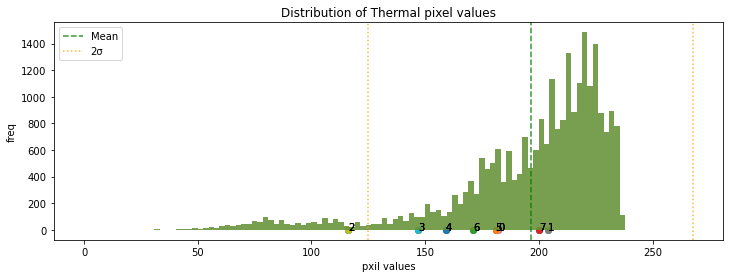

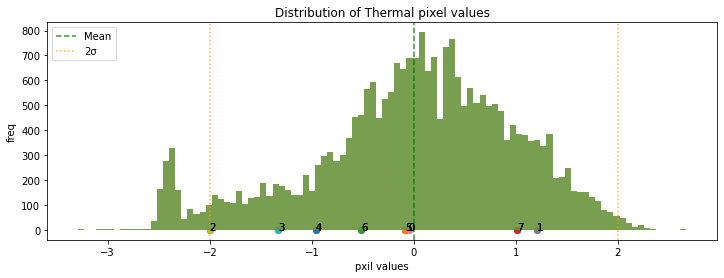

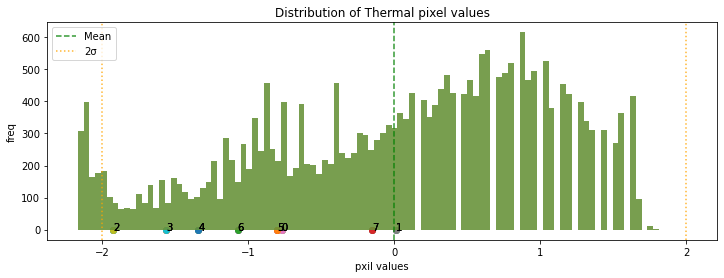

******* end *******
******* start *******
206.jpg
Module type_in_array: Normal
Module type_in_module: Multi-Hotspots


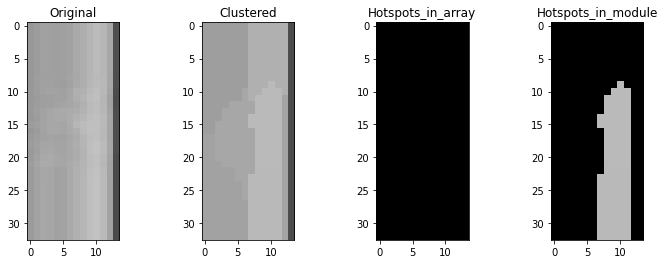

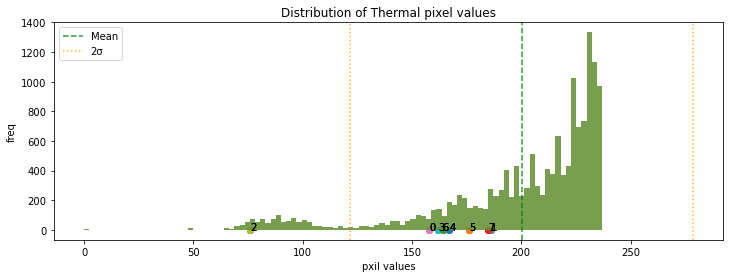

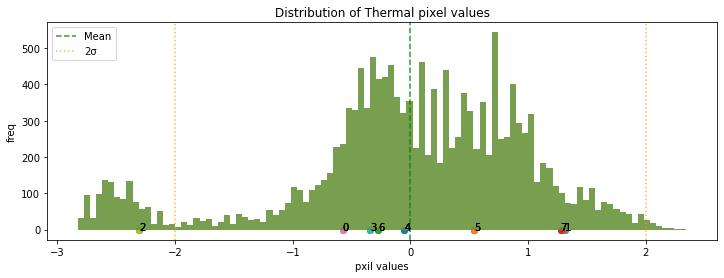

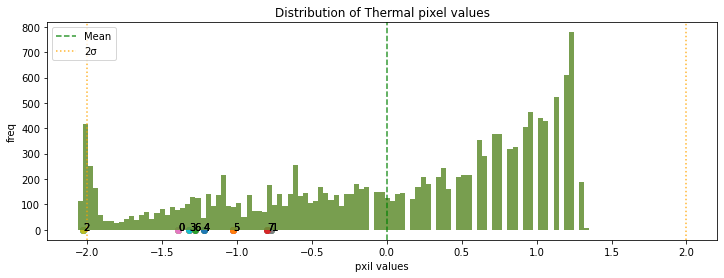

******* end *******
******* start *******
212.jpg
Module type_in_array: Normal
Module type_in_module: Multi-Hotspots


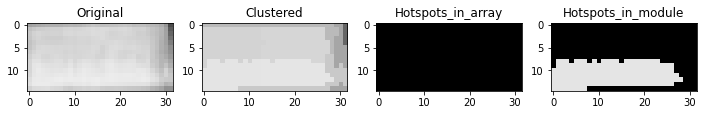

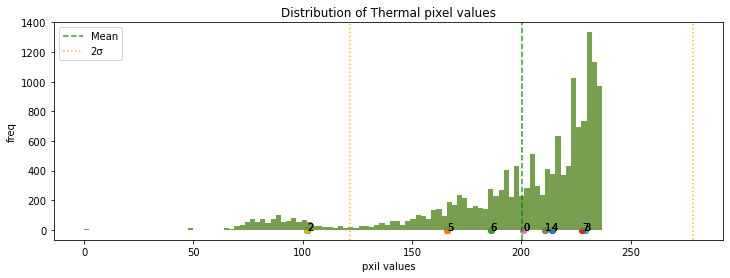

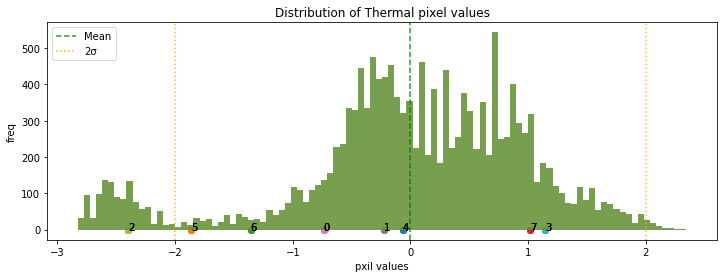

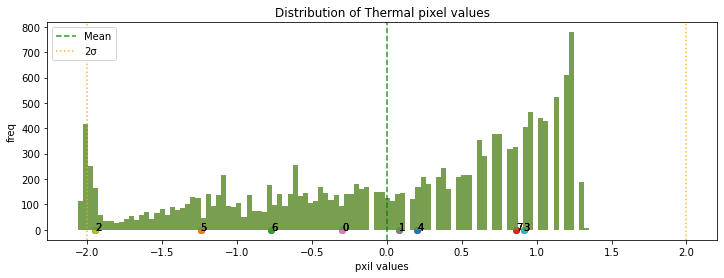

******* end *******
******* start *******
207.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


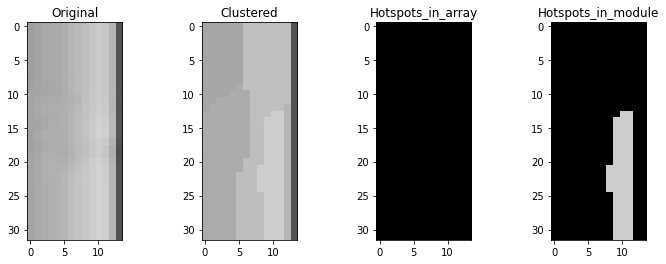

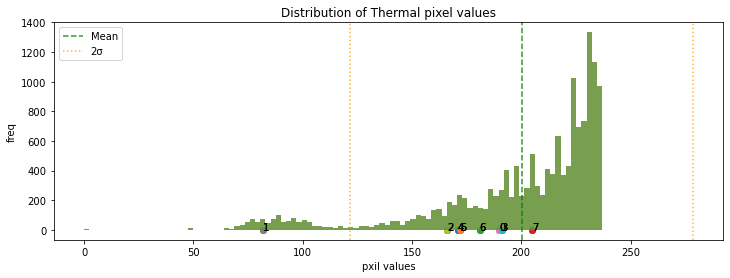

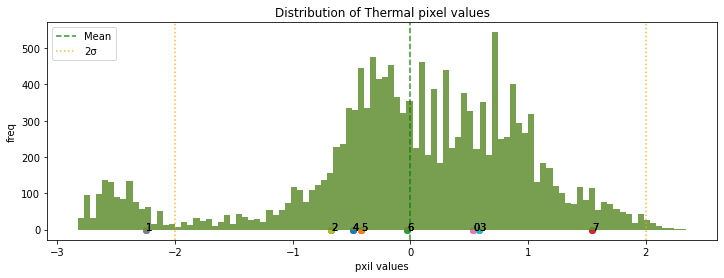

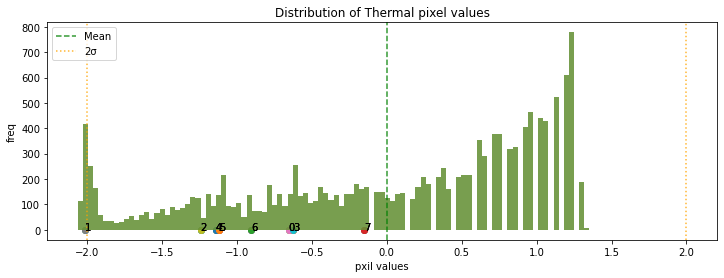

******* end *******
******* start *******
159.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


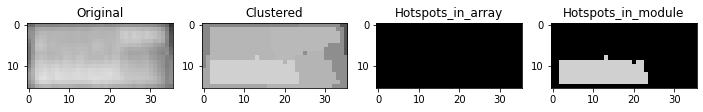

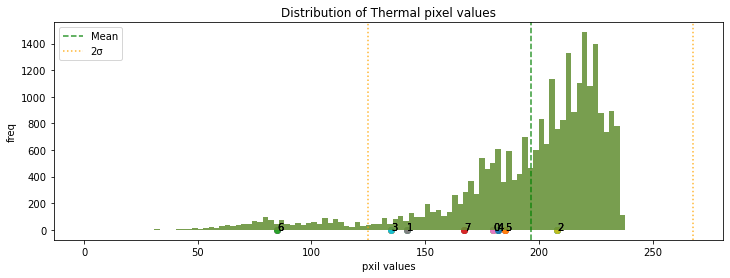

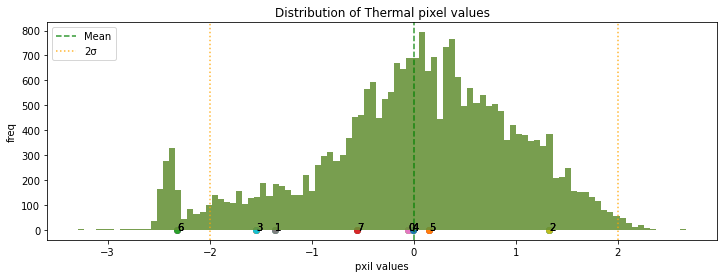

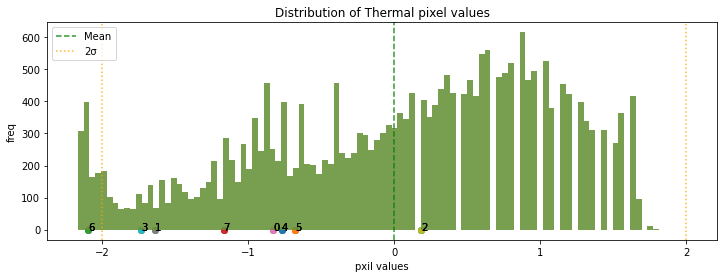

******* end *******
******* start *******
64.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


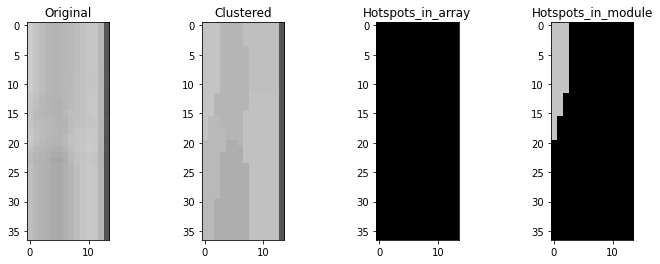

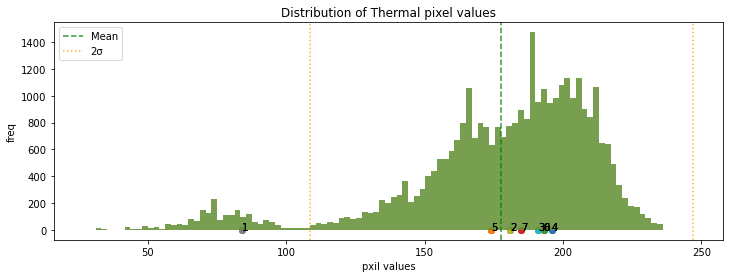

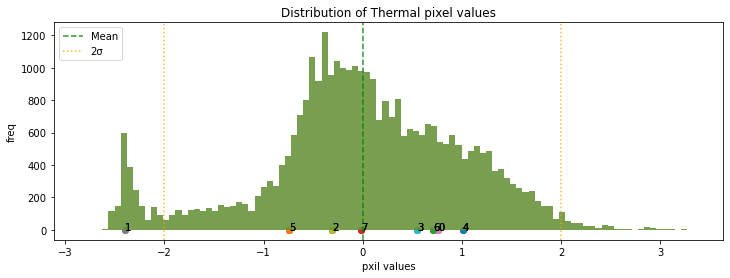

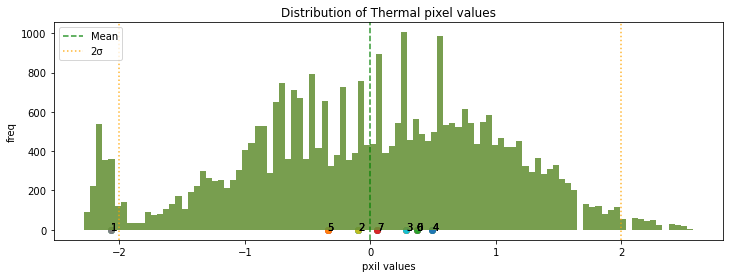

******* end *******
******* start *******
70.jpg
Module type_in_array: Normal
Module type_in_module: Normal


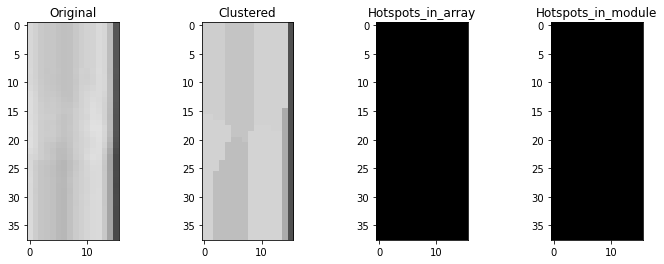

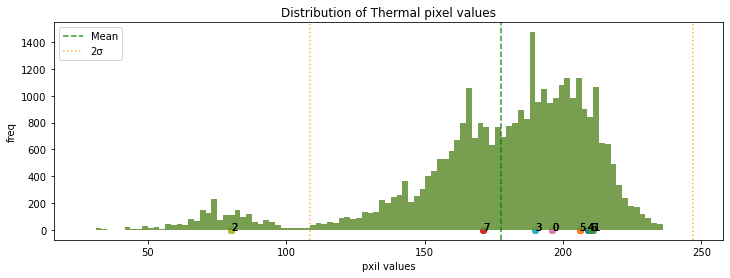

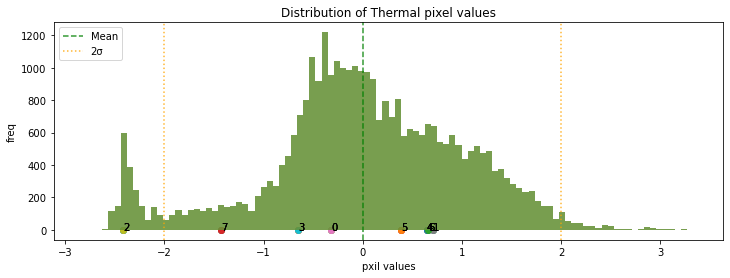

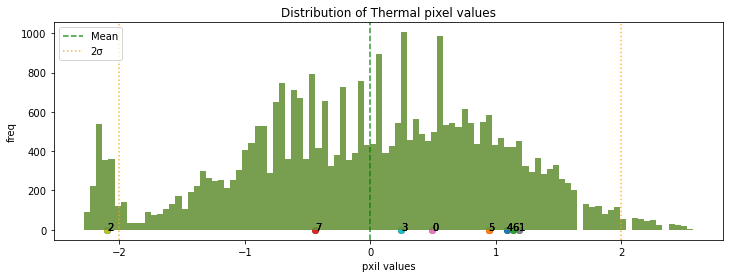

******* end *******
******* start *******
58.jpg
Module type_in_array: Single-Hotspot
Module type_in_module: Single-Hotspot


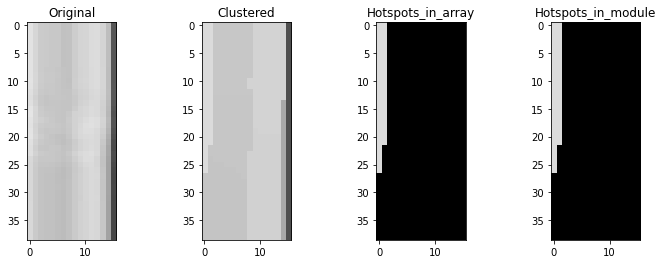

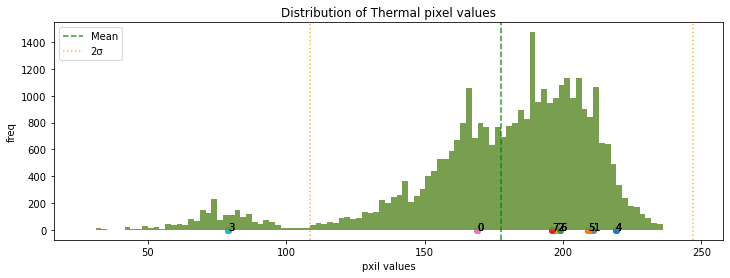

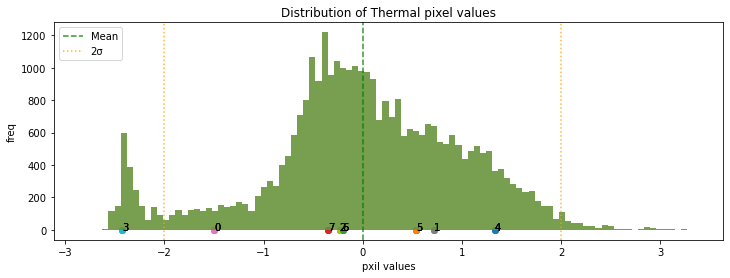

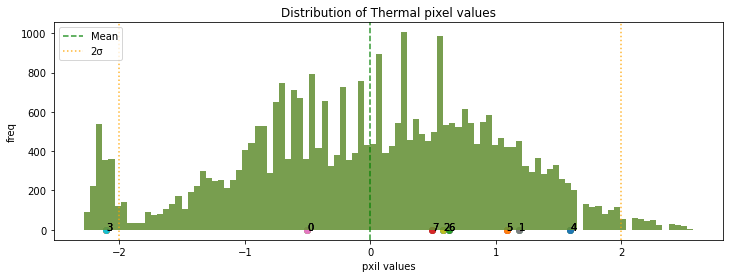

******* end *******
******* start *******
8.jpg
Module type_in_array: Single-Hotspot
Module type_in_module: Single-Hotspot


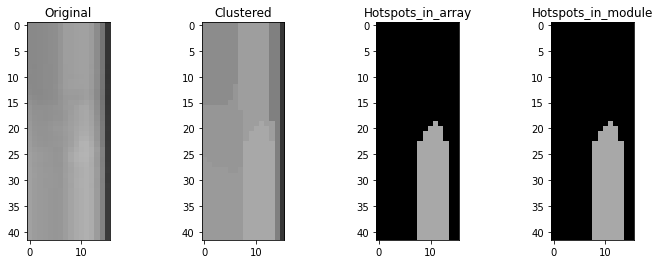

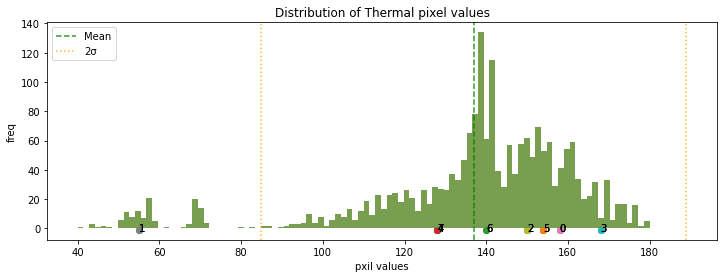

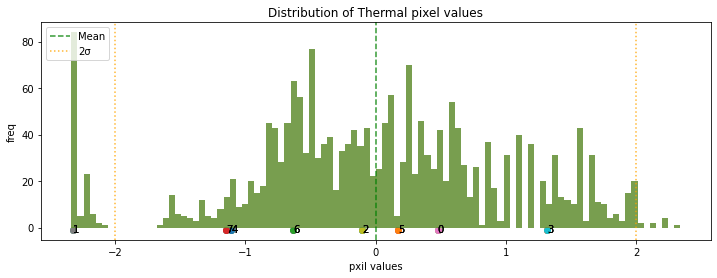

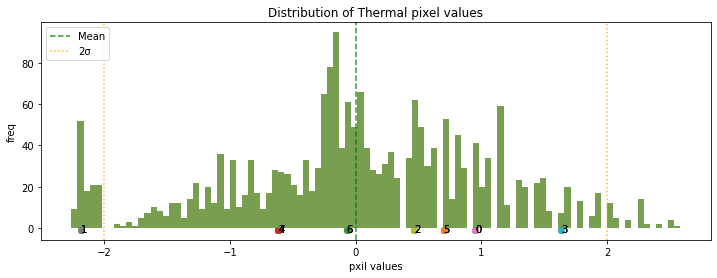

******* end *******
******* start *******
198.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


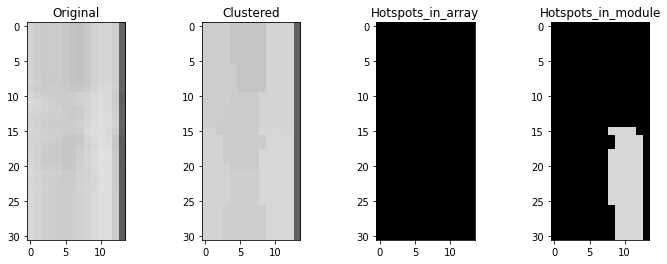

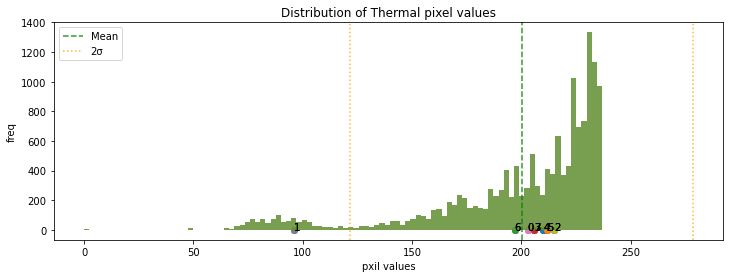

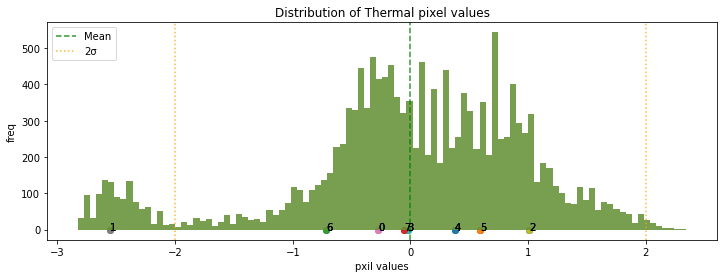

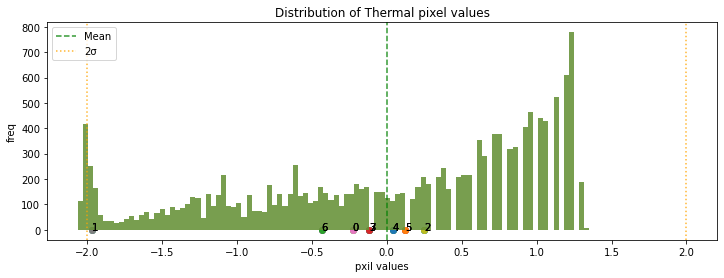

******* end *******
******* start *******
66.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


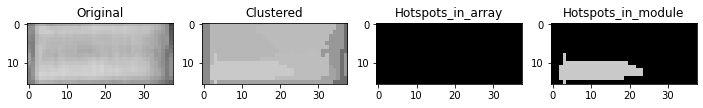

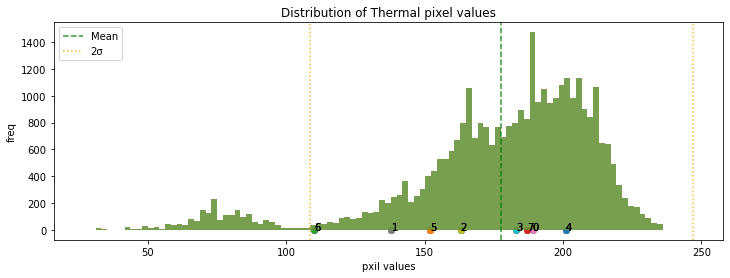

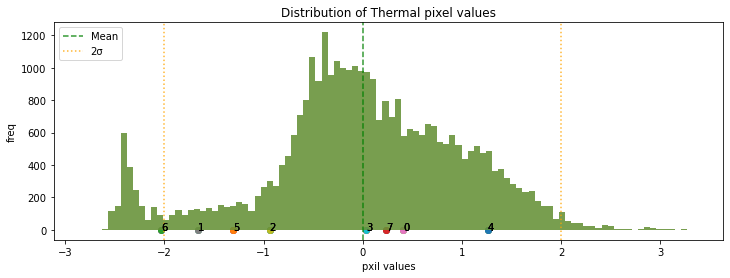

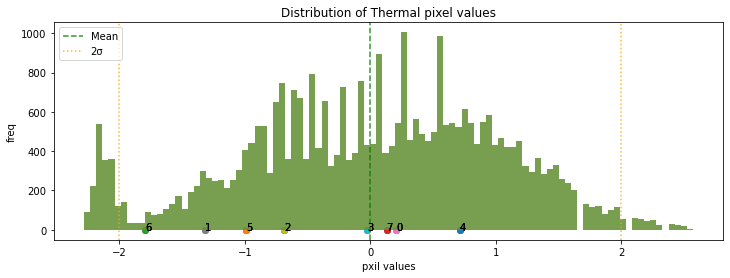

******* end *******
******* start *******
72.jpg
Module type_in_array: Single-Hotspot
Module type_in_module: Single-Hotspot


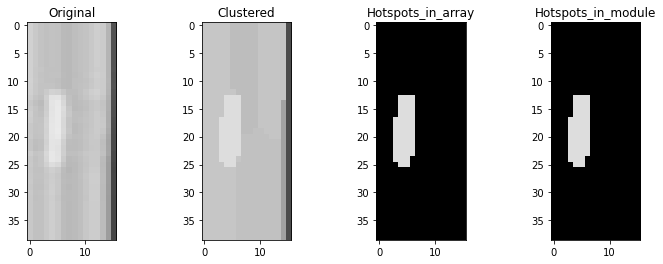

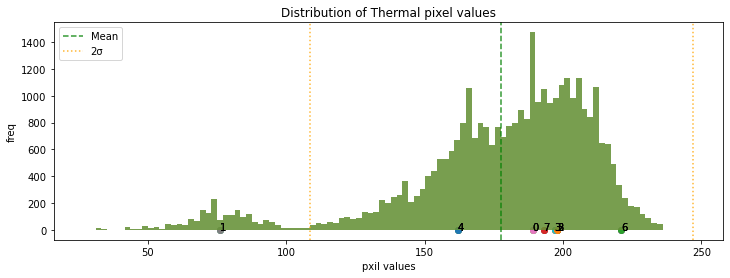

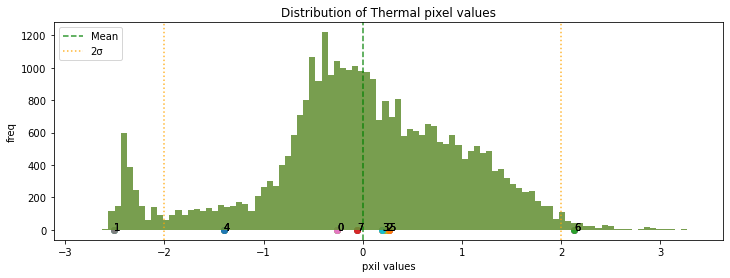

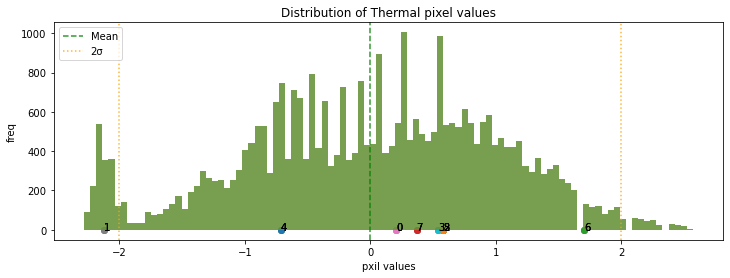

******* end *******
******* start *******
211.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


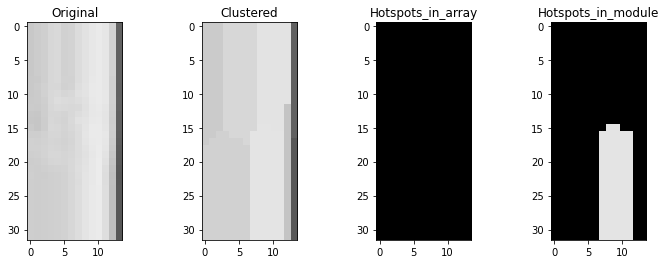

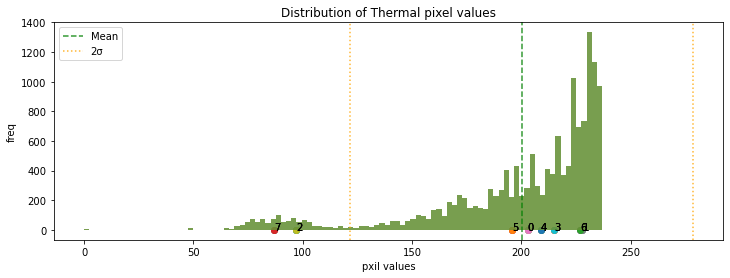

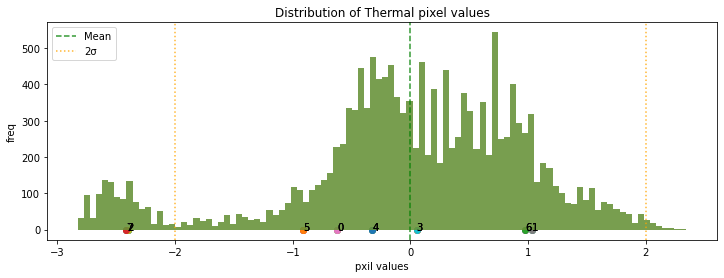

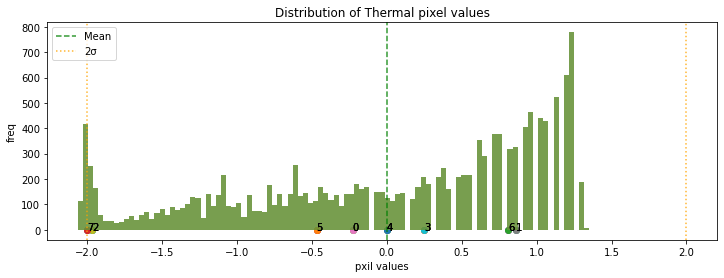

******* end *******
******* start *******
205.jpg
Module type_in_array: Normal
Module type_in_module: Multi-Hotspots


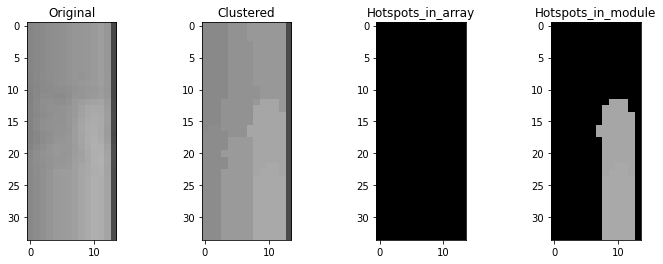

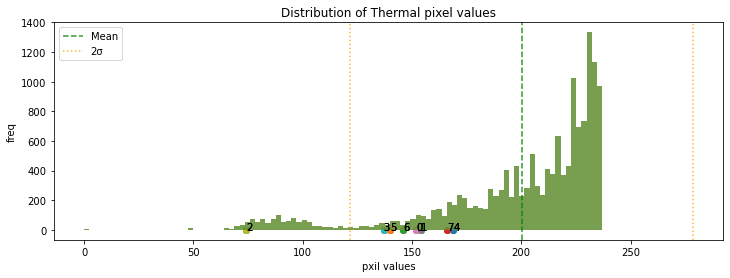

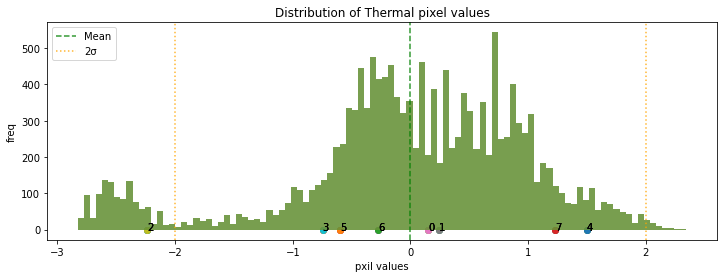

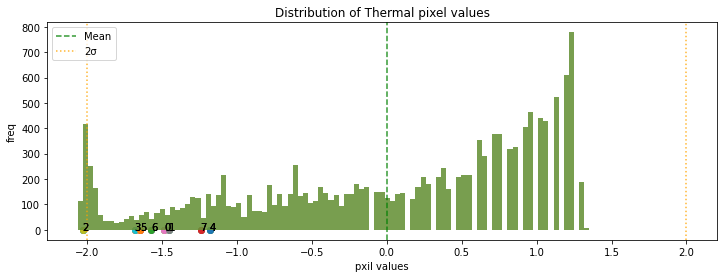

******* end *******
******* start *******
204.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


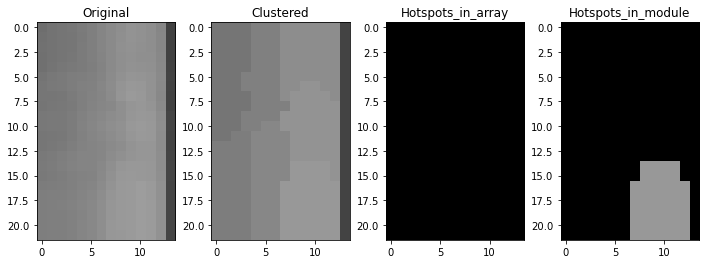

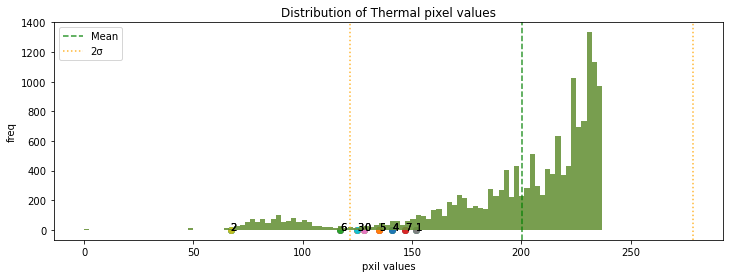

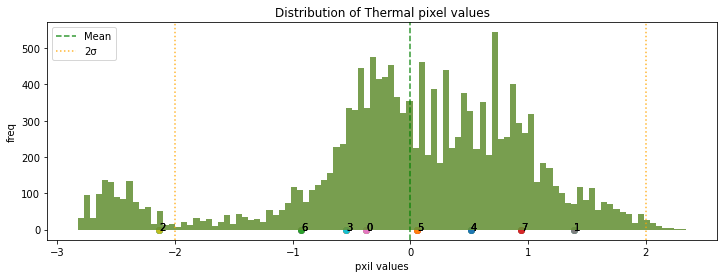

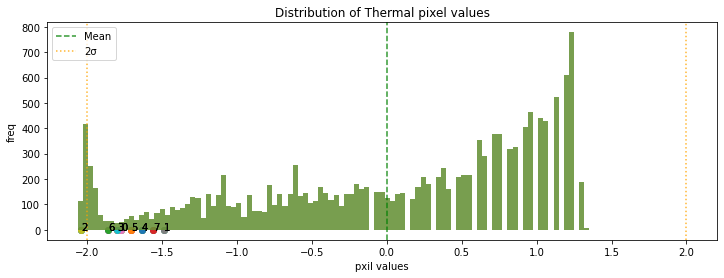

******* end *******
******* start *******
210.jpg
Module type_in_array: Normal
Module type_in_module: Multi-Hotspots


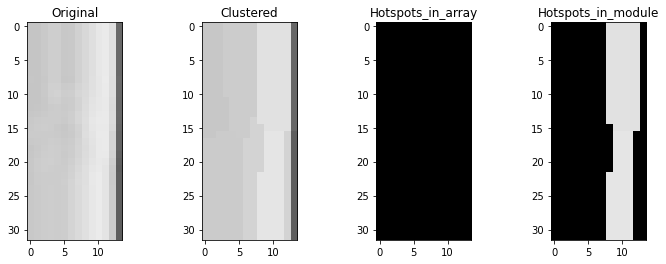

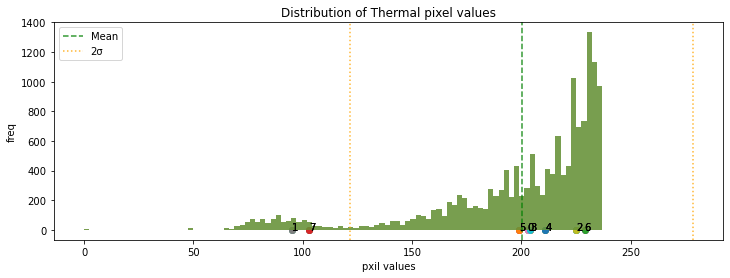

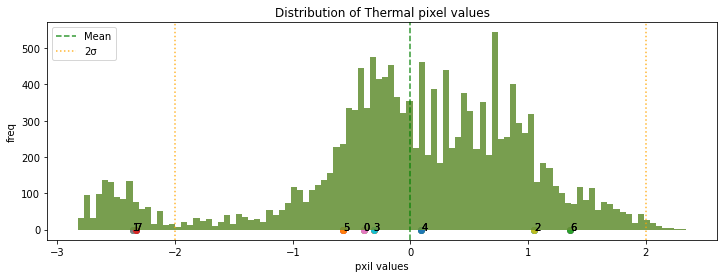

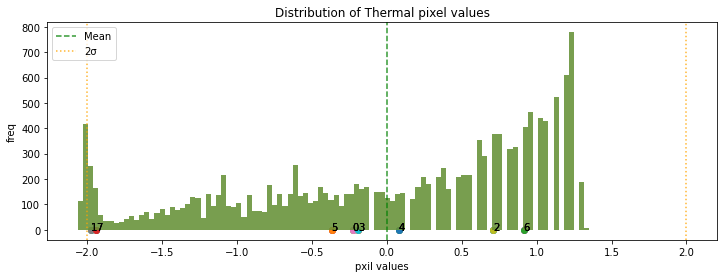

******* end *******
******* start *******
73.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


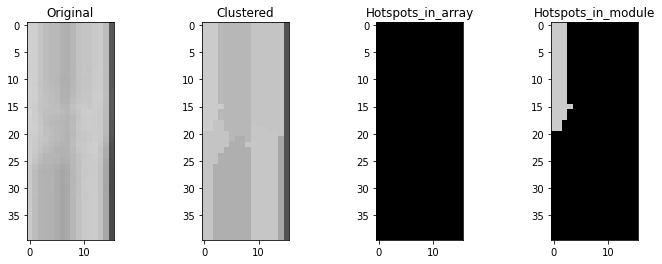

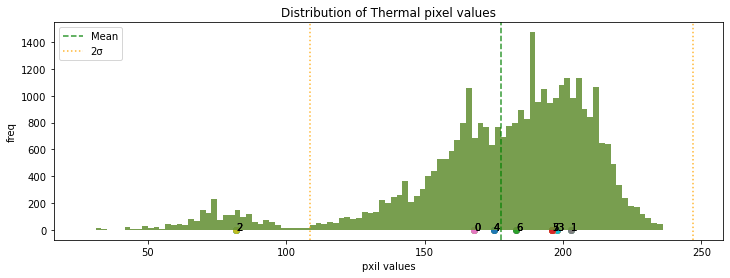

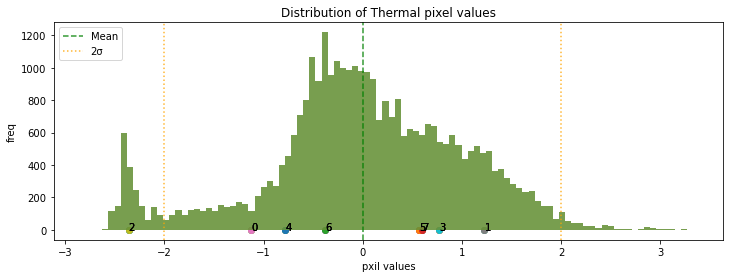

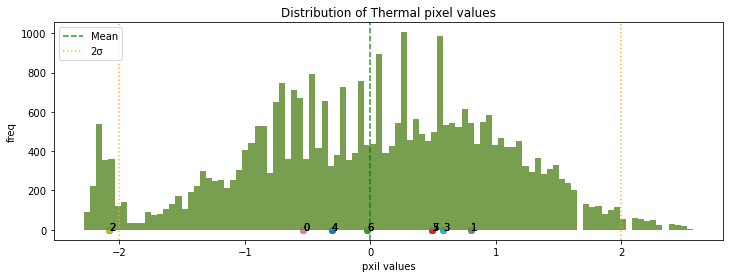

******* end *******
******* start *******
199.jpg
Module type_in_array: Normal
Module type_in_module: Normal


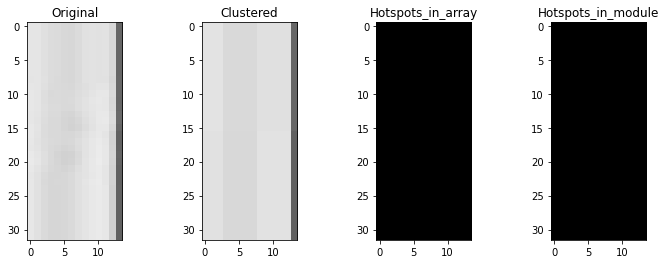

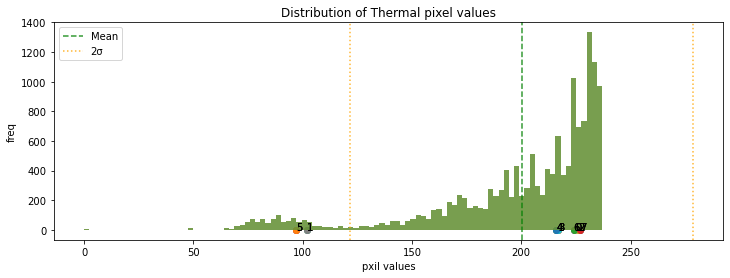

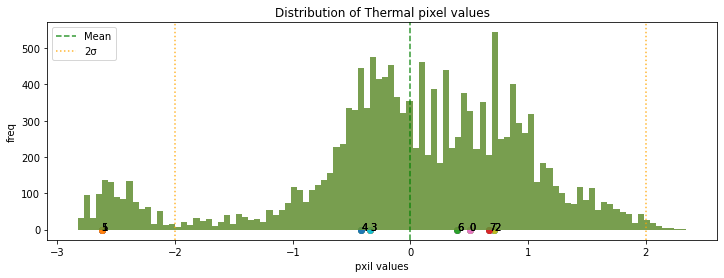

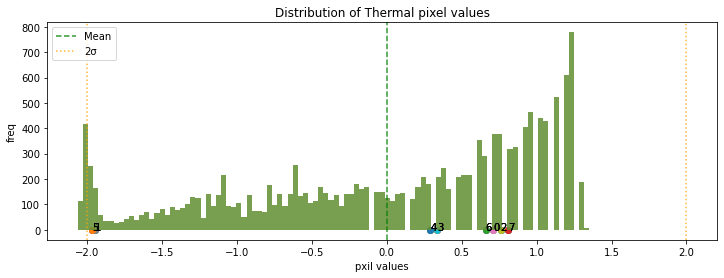

******* end *******
******* start *******
67.jpg
Module type_in_array: Single-Hotspot
Module type_in_module: Single-Hotspot


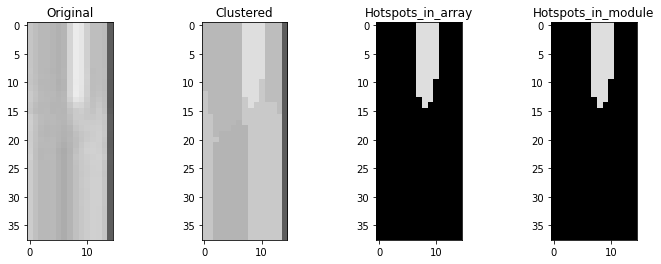

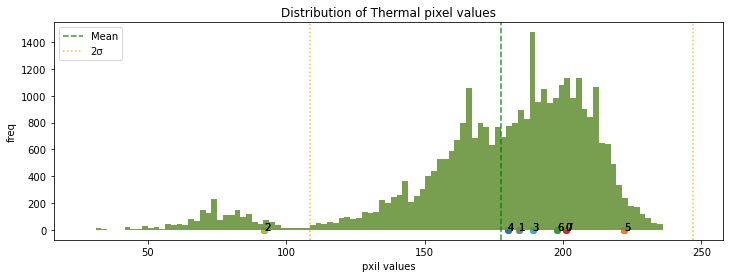

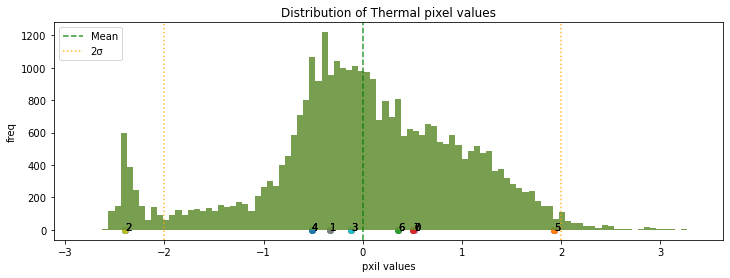

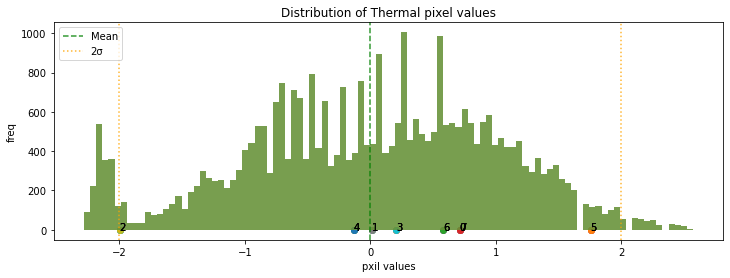

******* end *******
******* start *******
9.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


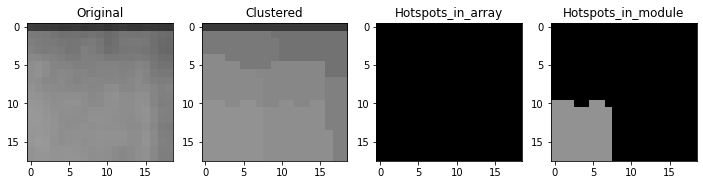

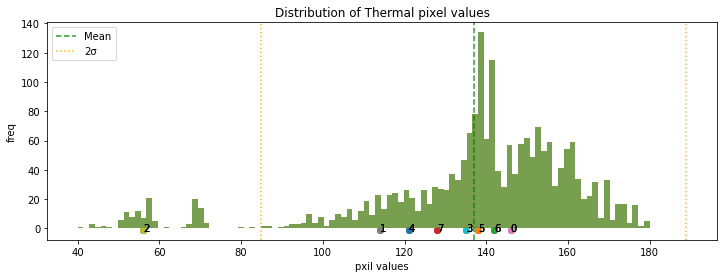

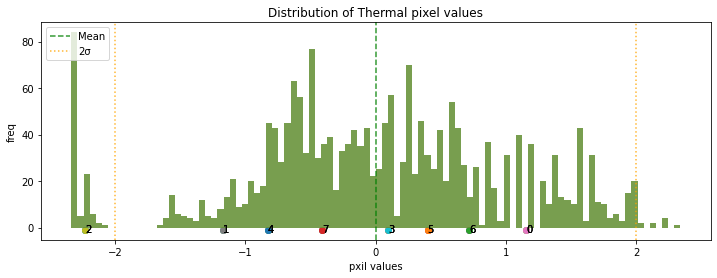

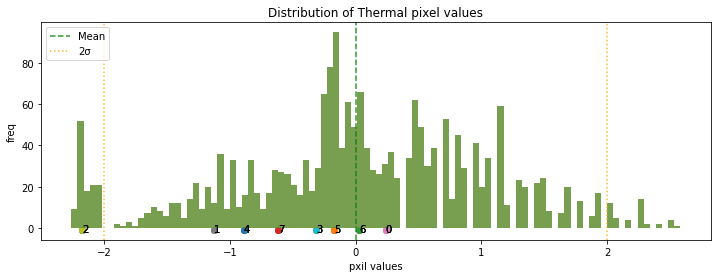

******* end *******
******* start *******
14.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


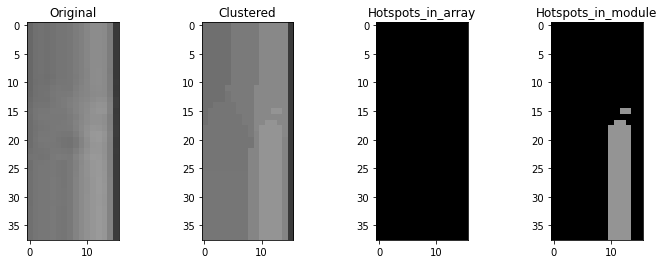

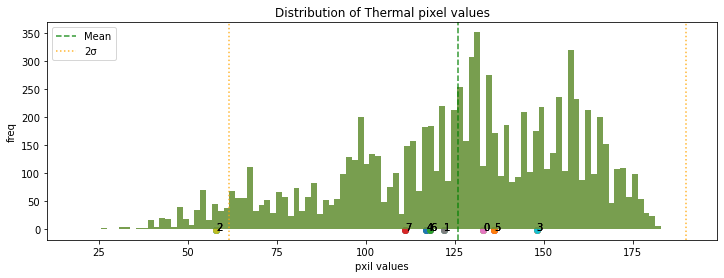

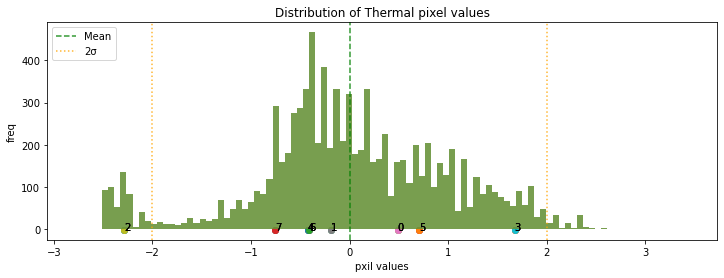

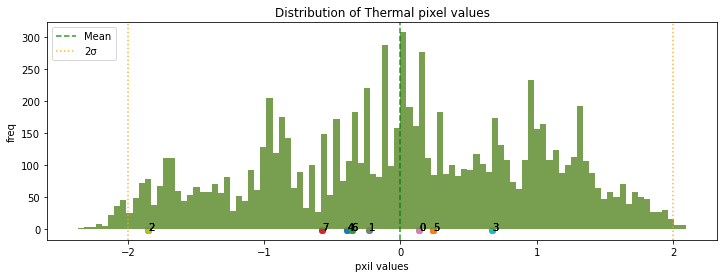

******* end *******
******* start *******
129.jpg
Module type_in_array: Normal
Module type_in_module: Normal


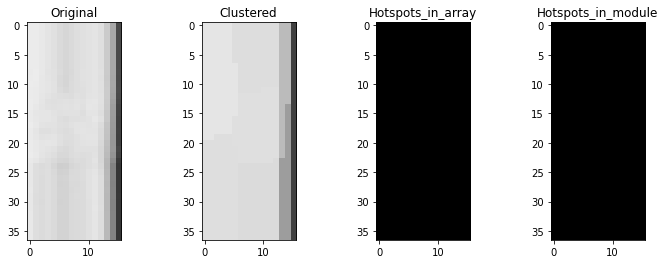

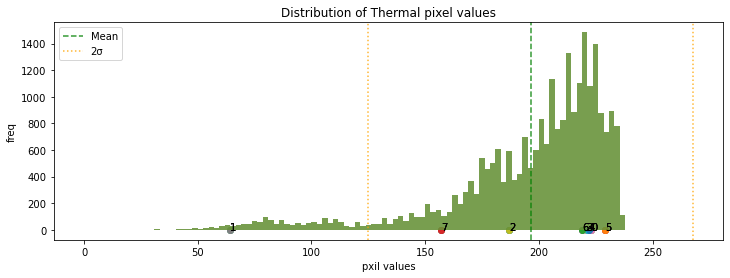

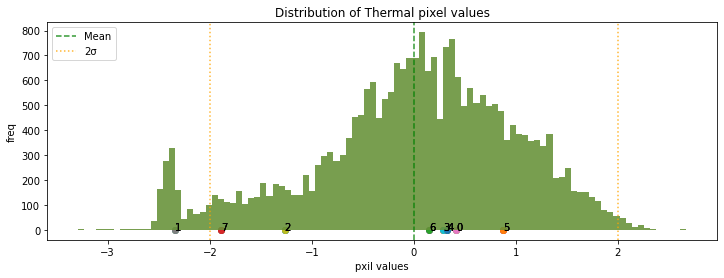

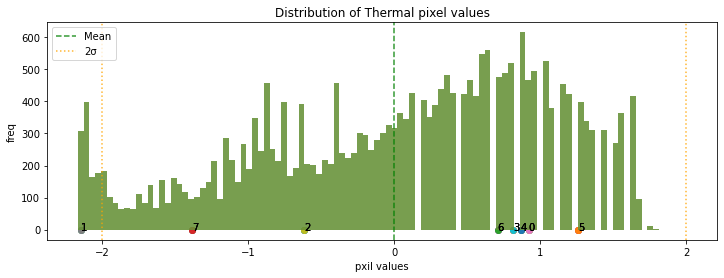

******* end *******
******* start *******
115.jpg
Module type_in_array: Normal
Module type_in_module: Normal


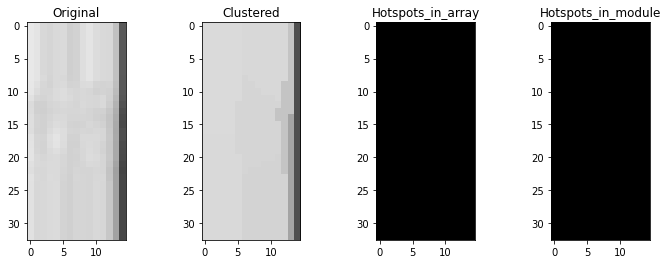

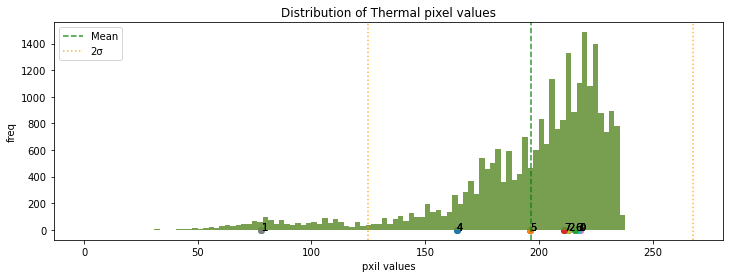

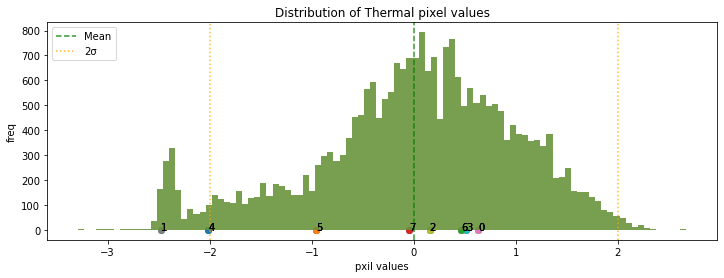

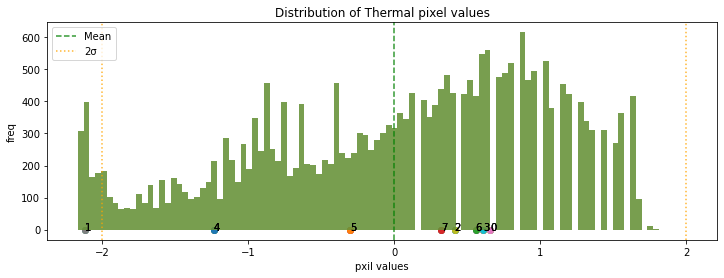

******* end *******
******* start *******
114.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


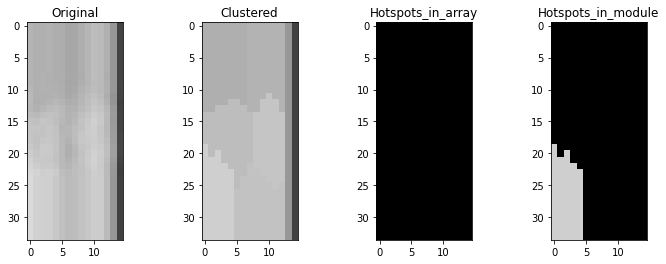

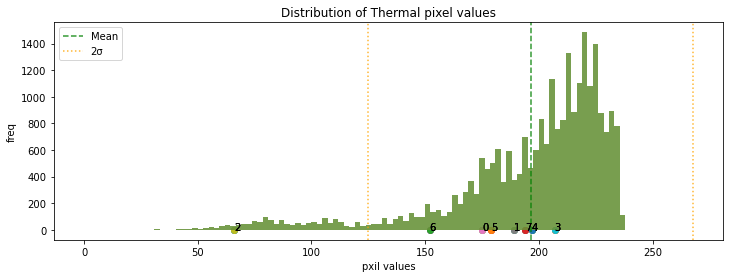

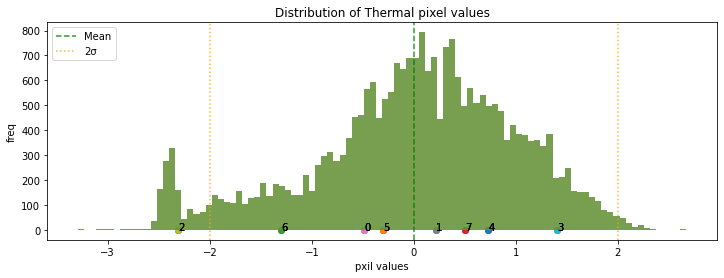

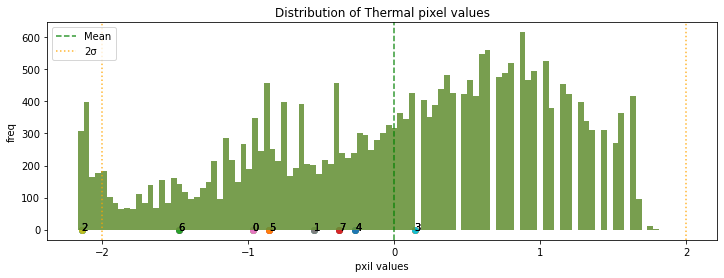

******* end *******
******* start *******
128.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


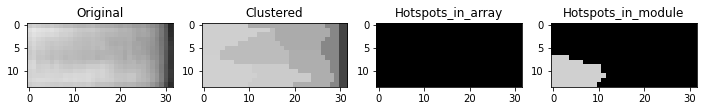

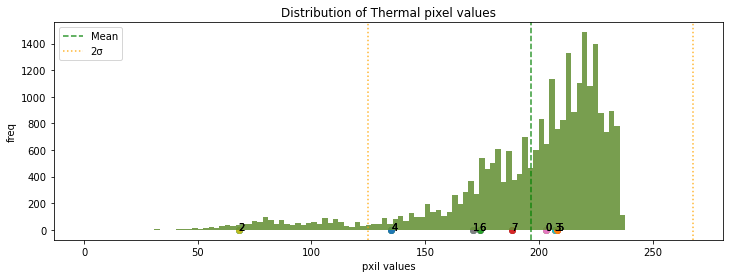

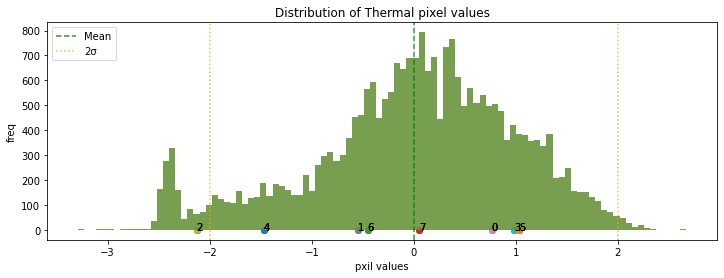

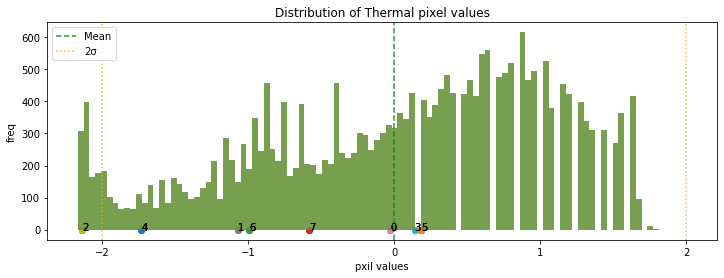

******* end *******
******* start *******
15.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


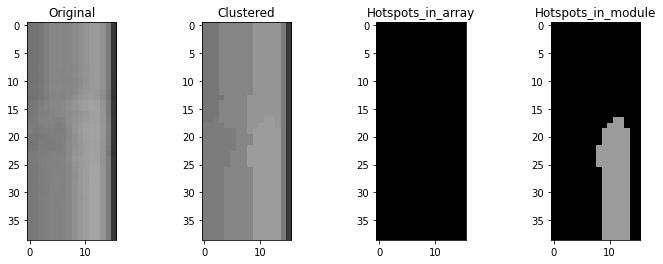

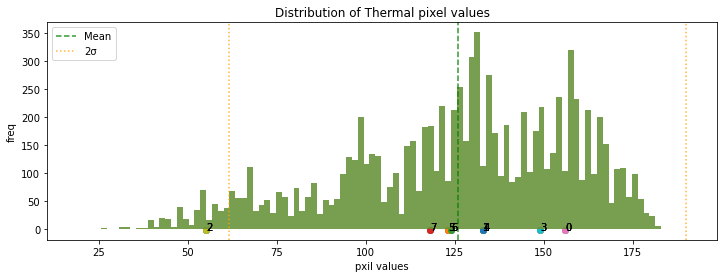

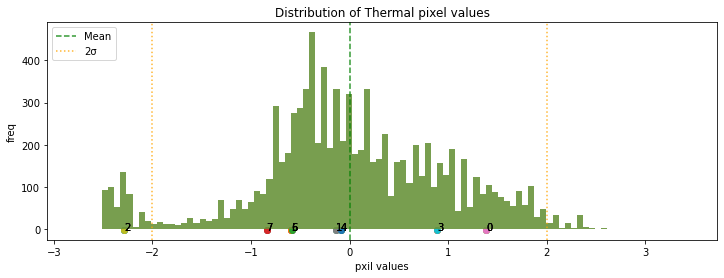

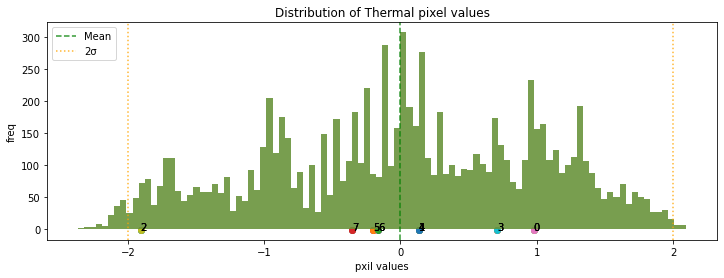

******* end *******
******* start *******
17.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


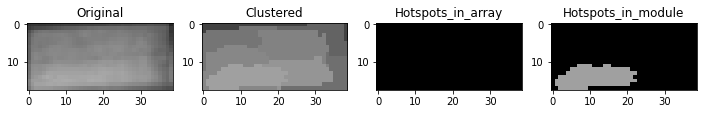

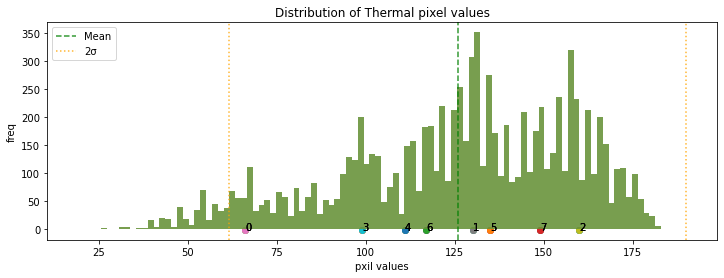

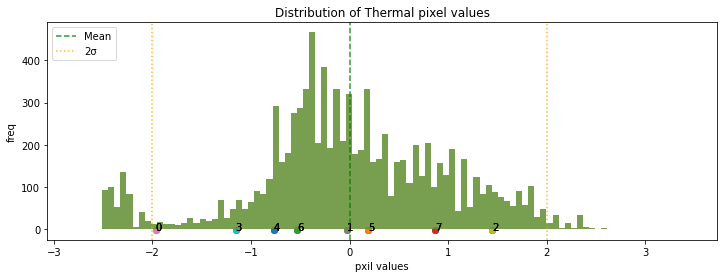

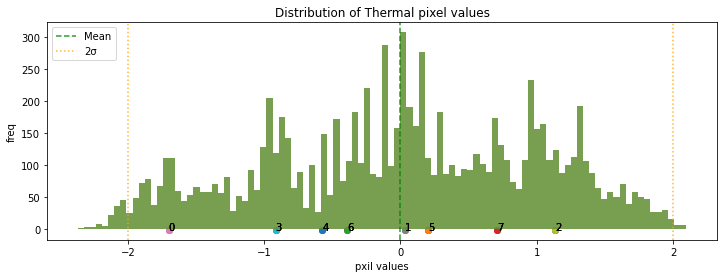

******* end *******
******* start *******
116.jpg
Module type_in_array: Normal
Module type_in_module: Normal


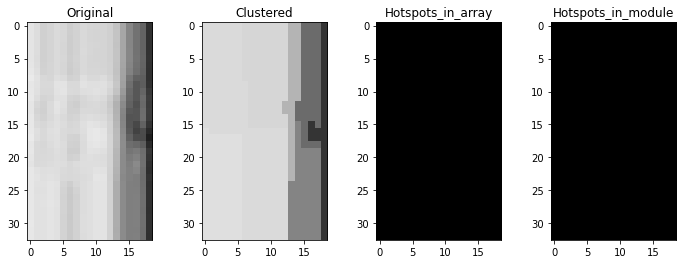

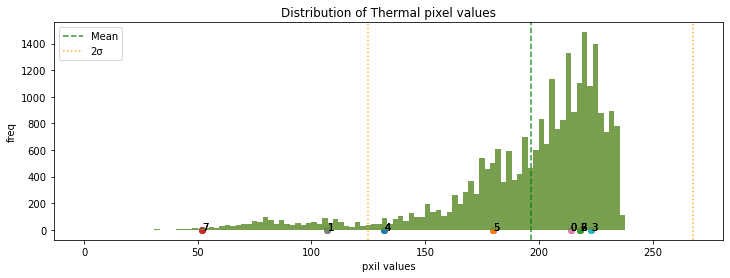

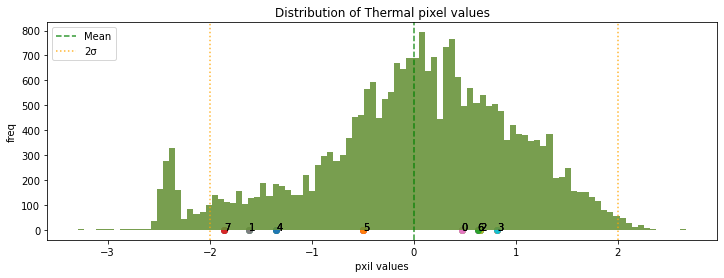

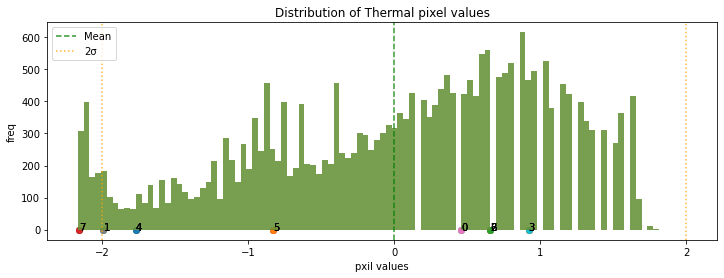

******* end *******
******* start *******
16.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


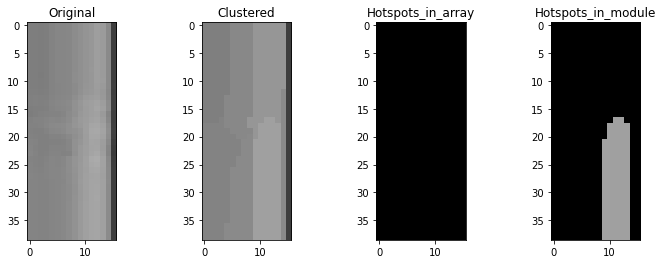

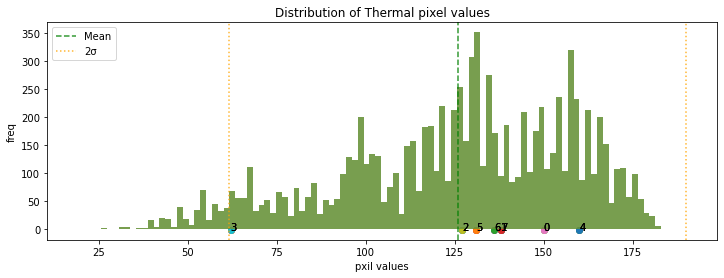

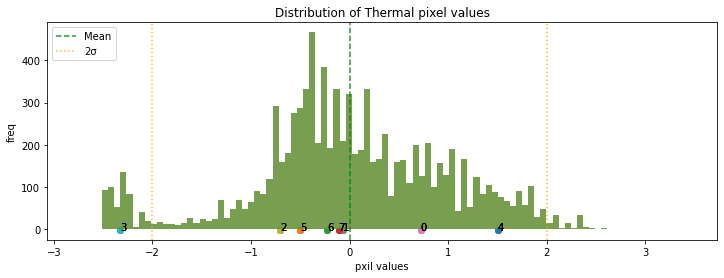

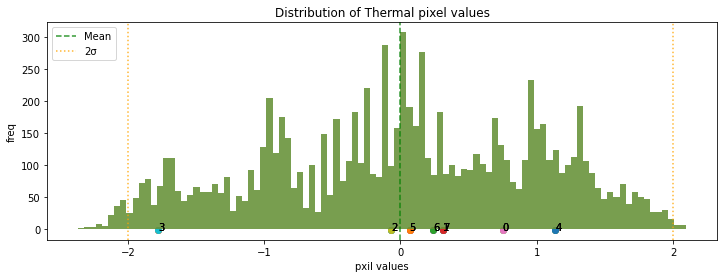

******* end *******
******* start *******
12.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


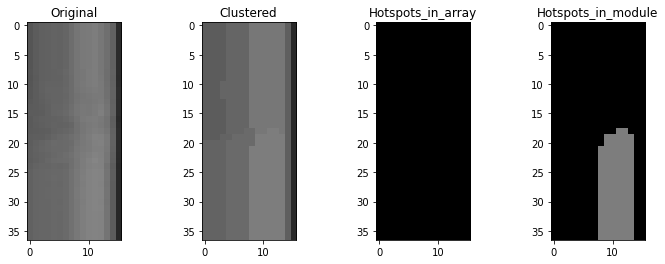

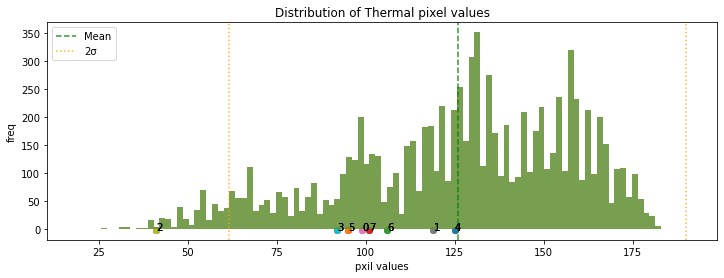

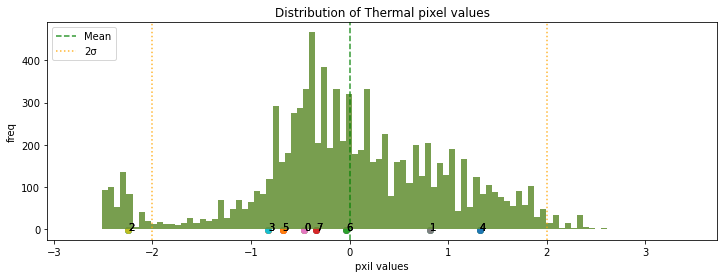

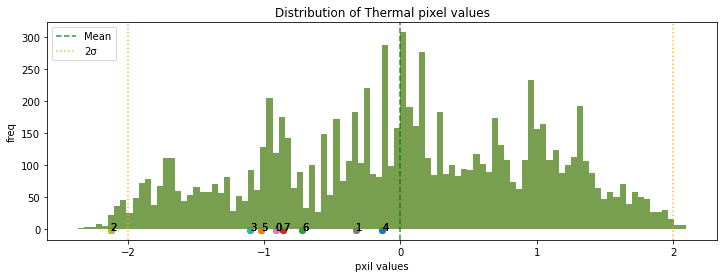

******* end *******
******* start *******
113.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


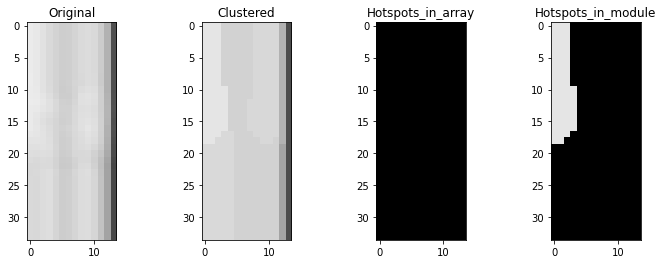

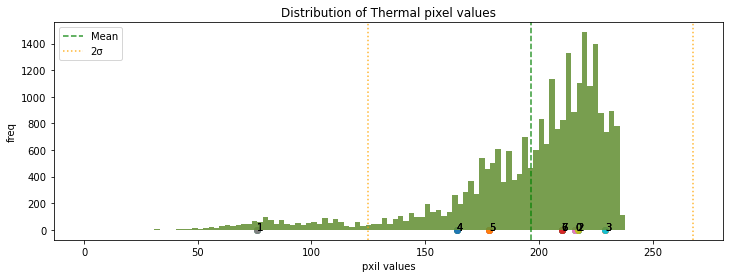

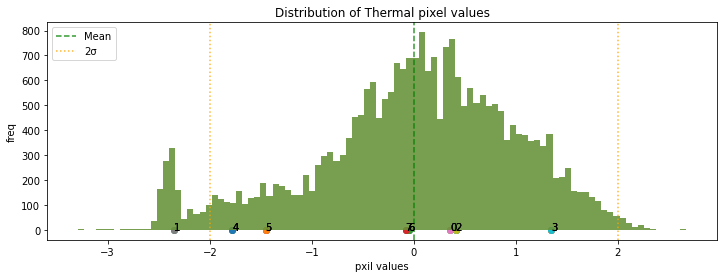

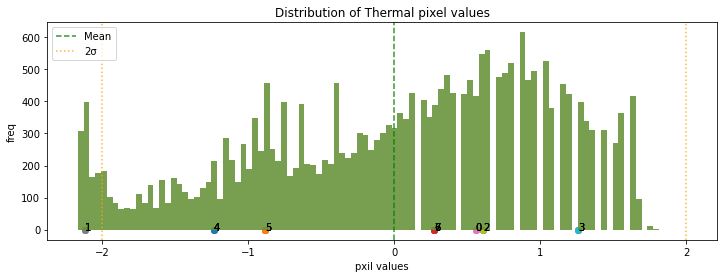

******* end *******
******* start *******
112.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


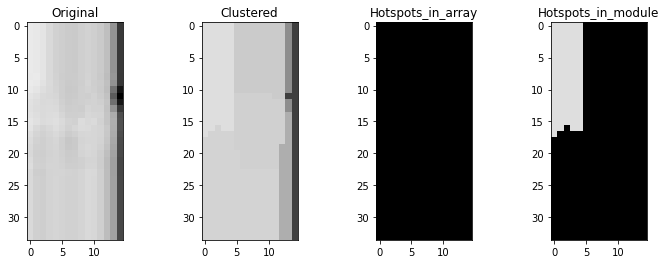

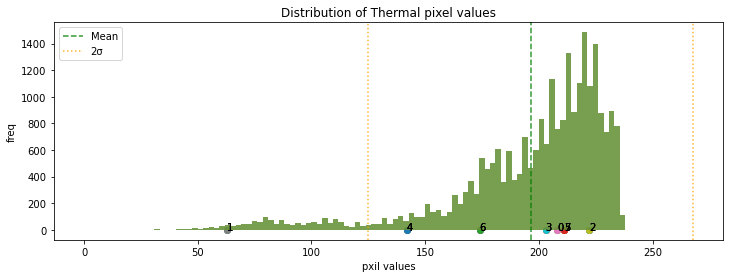

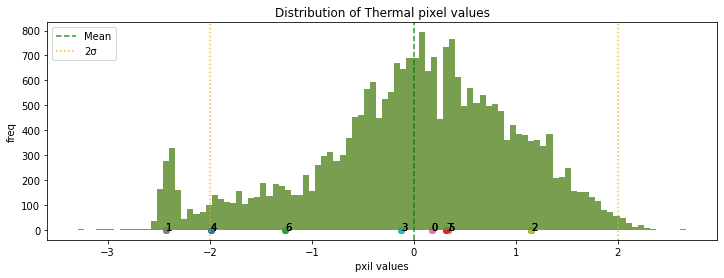

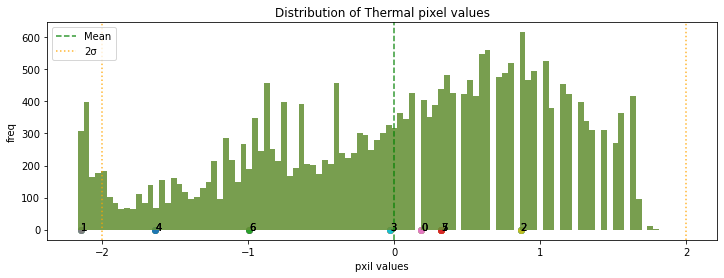

******* end *******
******* start *******
13.jpg
Module type_in_array: Normal
Module type_in_module: Single-Hotspot


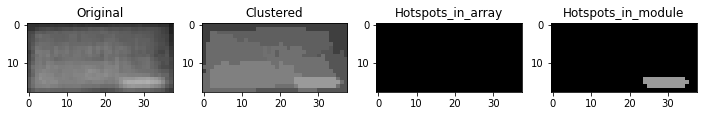

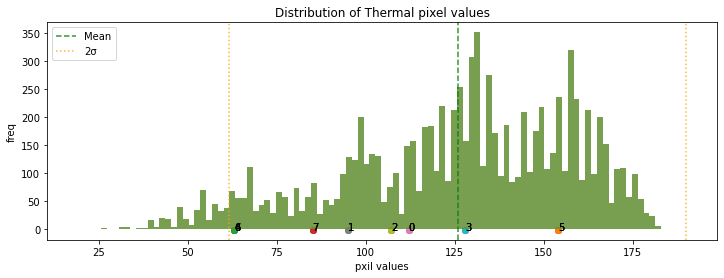

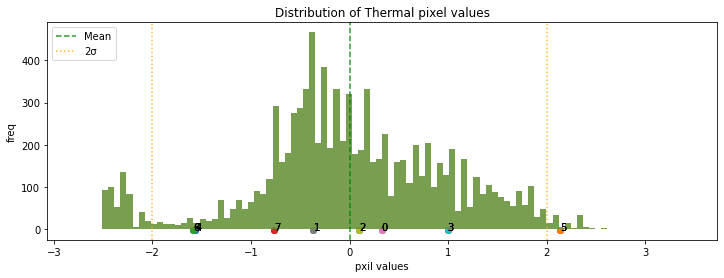

In [ ]:
#for n, k in enumerate(list(thermal_img_files)[:10]):
for n, k in enumerate(list(thermal_img_files)):    
    print("******* start *******")
    print(k)
    # -- module label --
    l = module_labels[n]
    # -- cluster temperature ---
    clusters = clustering.TemperatureClusters(
        data.scaled_temperature_with_index[k], method=clustering_method)  
    sliced_data = clusters.get_clusters_data(data_array[l].temperature[k])    
    clusters_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in sliced_data])
    #sliced_data = clusters.get_clusters_data(data_array[l].scaled_temperature[k])
    sliced_data = clusters.get_clusters_data(data_array[l].transformed_temperature[k])
    scaled_clusters_temperature = np.stack([t.mean(axis=0) for t in sliced_data ])
    # -- anomaly detection --    
    hot_pixels_in_array, hot_clusters_in_array = get_hotspots_in_array(
        clusters_temperature, l, thermal_img_files[k], log=False) 
    hot_pixels_in_module, hot_clusters_in_module = get_hotspots_in_module(
        scaled_clusters_temperature, thermal_img_files[k], log=False)     
    module_type_in_array = anomaly_detection.detect_module_type(
        hot_clusters_in_array, hot_pixels_in_array)
    module_type_in_module = anomaly_detection.detect_module_type(
        hot_clusters_in_module, hot_pixels_in_module)
    print("Module type_in_array:", module_type_in_array)
    print("Module type_in_module:", module_type_in_module)
    # -- save anomaly modules --
    if module_type_in_array not in anomaly_modules:
        anomaly_modules[module_type_in_array] = [k]
    else:
        anomaly_modules[module_type_in_array].append(k)
    # -- display -- 
    img_clustered = clusters_temperature[clusters.labels] 
    img_clustered = img_clustered.reshape(thermal_img_files[k].shape)
    img_hotspots_in_array = img_clustered * hot_pixels_in_array
    img_hotspots_in_module = img_clustered * hot_pixels_in_module
    display.display_modules({
        "Original": thermal_img_files[k], 
        "Clustered": img_clustered,
        "Hotspots_in_array": img_hotspots_in_array,
        "Hotspots_in_module": img_hotspots_in_module,
    })
    display.display_distributions(
        data_array[l].all_temperature,            
        filepath = "./hist/hist_" + k,
        cluster_centers = clusters_temperature
    )
    display.display_distributions(
        #data_array[l].scaled_all_temperature,         
        data_array[l].transformed_all_temperature,                 
        filepath = "./hist/hist_" + k,
        cluster_centers = scaled_clusters_temperature
    )
    display.display_distributions(
        array_scaler[l].transform(data_array[l].all_temperature),
        filepath = "./hist/hist_" + k,
        cluster_centers = array_scaler[l].transform(clusters_temperature)
    )
    print("******* end *******")

In [ ]:
import json
tmp = open("anomaly_modules.json", "w")
json.dump(anomaly_modules, tmp, indent=4, sort_keys=True, separators=(',', ': '))
tmp.close()

In [ ]:
# モジュール抽出

In [ ]:
filters = Filters(thermal_npdat_path)

In [ ]:
img_org = cv2.imread(input_img_path, 0)
img_filtered = filters.apply_all_filters(img_org)

In [ ]:
# 異常モジュール可視化

In [ ]:
with open('anomaly_modules.json', 'r') as f:
    anomaly_modules = json.load(f)

In [ ]:
modules = Modules(img_filtered, anomaly_modules)

In [ ]:
anomaly_contours = modules.get_anomaly_contours()

In [ ]:
color_list = {
    "Single-Hotspot": (0,255,255), # aqua
    "Multi-Hotspots": (0,255,0), # green
    "Cluster-Anomaly": (255,255,0), # yellow
    "Module-Anomaly": (255,165,0), # orange
}
img_target_index = modules.get_img_contours(img_org, index=False)
for k, v in anomaly_contours.items():
    if k == "Normal":
        continue
    else:
        img_target_index = modules.get_img_target_contours(
            img_target_index, v, index=True, color=color_list[k])
module_extraction.show_img(
    {"highlighted modules":img_target_index}, cmap="gray", figsize=(30,30)
)

In [ ]:
string_anomaly_labels = modules.get_string_anomaly_labels(anomaly_contours["Module-Anomaly"])

In [ ]:
img_string_index = modules.get_img_target_contours(
    modules.get_img_contours(img_org, index=False),
    anomaly_contours["Module-Anomaly"][string_anomaly_labels>=0], 
    index=True, color=(238,130,238)) # violet

In [ ]:
module_extraction.show_img({"string-anomaly modules":img_string_index},cmap="gray",figsize=(30,30))

In [ ]:
#ToDo
## 異常部分へのマーキング（赤で囲む）
## 分類モデルの改良
## log scale in module